In [1]:
# 다른 경로에 있는 모듈을 가져오기 위해 절대 경로 추가

import os
import sys

root = os.path.join(os.path.abspath(os.getcwd()), '..', '..')
root = os.path.normpath(root)

if root not in sys.path:
    sys.path.insert(0, root)

In [2]:
# 필요한 라이브러리 로드

import emoji
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import re
import torch
from communav.utils import db
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from soynlp.normalizer import repeat_normalize
from tqdm import tqdm
from transformers import AutoModelForSequenceClassification, AutoTokenizer, get_linear_schedule_with_warmup

/tmp/ipykernel_790634/2000937440.py:8: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
# 카테고리 정의

CATEGORIES = {
    0: '자유',
    1: '학사',
    2: '장학 · 행정',
    3: '학교생활',
    4: '수업',
    5: '수업/이과',
    6: '수업/문과',
    7: '캠퍼스',
    8: '취업 · 진로',
    9: '일상생활',
    10: '음식점 · 카페',
    11: '취미 · 여가',
    12: '인간관계',
    13: '병역'
}

In [4]:
# 파라미터 설정

TABLE_NAME = 'everytime_article_dataset_v1'
MODEL_ID = 'beomi/KcELECTRA-base-v2022'
TOKENIZER_ID = 'beomi/KcELECTRA-base-v2022'
SEED = 42
USE_RANDOM_SEED = True
NUM_LABELS = len(CATEGORIES)
MAX_LENGTH = 128
METRIC_AVERAGE = 'weighted'
METRIC_ZERO_DIVISION = 0
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 2e-5
SAVE_PATH = '.'

In [5]:
# 랜덤 시드 고정

if torch.cuda.is_available():
    device = torch.device('cuda')
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')
    print('No GPU available, using the CPU instead.')

if not USE_RANDOM_SEED:
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    if device.type == 'cuda':
        torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 3060 Ti


In [6]:
# 커뮤니티 게시글 데이터 로드

connection = db.get_connection()
cursor = connection.cursor()

cursor.execute(f'''
    SELECT id, title, text, category_id
    FROM {TABLE_NAME}
    WHERE category_id IS NOT NULL
''')
original_articles = cursor.fetchall()
print(f'Loaded {len(original_articles)} articles.')

cursor.close()
db.close_connection()

Connected to DB successfully.
Loaded 4712 articles.


In [7]:
# 가져온 데이터의 일부를 출력

for article in original_articles[:20]:
    print(article)

{'id': 1, 'title': '어제 비마관 화장실에서 핸드폰 찾아주신분!', 'text': '제가 경황이 없어서 감사하다고도 못 했네요.\n정말 감사합니다!!!', 'category_id': 9}
{'id': 3, 'title': '조은문화사 몇시에 보통 열리나요??', 'text': '1교시 수업 책 찾아야되서', 'category_id': 7}
{'id': 4, 'title': '전공수업듣는데', 'text': '복학한거처럼 보이는 형이 열심히는 하시던데 뭔가 군대갔다고오고 모든걸 까먹은 자기를 자책하듯이 수업듣는걸 보고 나도 3년후에 저러겠구나 싶더라... ㅠㅠ', 'category_id': 4}
{'id': 5, 'title': '정문에 있는 인쇄집들 몇시까지 하는지 아시나요?', 'text': '9시 넘어야 갈수있을거 같은데\n열어 있을지..', 'category_id': 7}
{'id': 8, 'title': '문화유목시대 교재뭔가요', 'text': '정정기간때 신청해서 잘 모르겠어요. ㅠㅠ 계획서보니까 고른다고하는데 뭐에요?', 'category_id': 6}
{'id': 13, 'title': '전자회로실험 파형이 물결처럼 나와야하는데 왜 난 일자로 나오지???;;', 'text': '이번에 복학해서 실험들으려는데 그냥 예비는 똑같이 따라하면 되는거 아닌가?\n왜 일자로만 나와....', 'category_id': 5}
{'id': 14, 'title': '전자회로실험 파형이 물결처럼 나와야하는데 왜 난 일자로 나오지???;;', 'text': '이번에 복학해서 실험들으려는데 그냥 예비는 똑같이 따라하면 되는거 아닌가?\n왜 일자로만 나와....\n이건 회로인데 뭐가 잘못된거지요????;;', 'category_id': 5}
{'id': 17, 'title': '컴퓨터구조 책삽니다', 'text': '표지에 컴퓨터구조 및 설계 써있고 5판 한글판 중고 2만원에삽니다\nPatterson , Hennessy 저자 입니다', 'category_

In [8]:
# 데이터 전처리 함수 정의

normal_pattern = re.compile(r'[^ .,?!/@$%~％·∼()\x00-\x7Fㄱ-ㅣ가-힣]+')
url_pattern = re.compile(r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)')

def preprocess(value):
    value = normal_pattern.sub(' ', value)
    value = emoji.replace_emoji(value, replace='')
    value = url_pattern.sub('', value)
    value = repeat_normalize(value, num_repeats=2)
    value = value.strip()
    return value

In [9]:
# 데이터 전처리

preprocessed_articles = []

for article in tqdm(original_articles):
    title = article['title']
    text = article['text']
    content = (title + ' ' + text).replace('\n', ' ')

    preprocessed_articles.append({
        'content': preprocess(content),
        'label': article['category_id']
    })

100%|██████████| 4712/4712 [00:00<00:00, 21931.34it/s]


In [10]:
# 전처리된 데이터의 일부를 출력

for article in preprocessed_articles[:20]:
    print(article)

{'content': '어제 비마관 화장실에서 핸드폰 찾아주신분! 제가 경황이 없어서 감사하다고도 못 했네요. 정말 감사합니다!!!', 'label': 9}
{'content': '조은문화사 몇시에 보통 열리나요?? 1교시 수업 책 찾아야되서', 'label': 7}
{'content': '전공수업듣는데 복학한거처럼 보이는 형이 열심히는 하시던데 뭔가 군대갔다고오고 모든걸 까먹은 자기를 자책하듯이 수업듣는걸 보고 나도 3년후에 저러겠구나 싶더라... ㅠㅠ', 'label': 4}
{'content': '정문에 있는 인쇄집들 몇시까지 하는지 아시나요? 9시 넘어야 갈수있을거 같은데 열어 있을지..', 'label': 7}
{'content': '문화유목시대 교재뭔가요 정정기간때 신청해서 잘 모르겠어요. ㅠㅠ 계획서보니까 고른다고하는데 뭐에요?', 'label': 6}
{'content': '전자회로실험 파형이 물결처럼 나와야하는데 왜 난 일자로 나오지???;; 이번에 복학해서 실험들으려는데 그냥 예비는 똑같이 따라하면 되는거 아닌가? 왜 일자로만 나와....', 'label': 5}
{'content': '전자회로실험 파형이 물결처럼 나와야하는데 왜 난 일자로 나오지???;; 이번에 복학해서 실험들으려는데 그냥 예비는 똑같이 따라하면 되는거 아닌가? 왜 일자로만 나와.... 이건 회로인데 뭐가 잘못된거지요????;;', 'label': 5}
{'content': '컴퓨터구조 책삽니다 표지에 컴퓨터구조 및 설계 써있고 5판 한글판 중고 2만원에삽니다 Patterson , Hennessy 저자 입니다', 'label': 5}
{'content': '오늘 영화의 이해 수업 영화의 이해 유양근 교수님 수업을 못가서 그런데 혹시 교재같은거나 해오라고 하신거 있나요?! ㅜㅜ', 'label': 6}
{'content': '초급일본어 전유나 초급일본어 책필요한가요?', 'label': 6}
{'content': '졸업학점있잖아 교양 30 전공 60 선택50 이면 무조건 저거

In [11]:
# 데이터 분포 확인 함수 정의

def plot_distribution(articles):
    label_counts = {category_id: 0 for category_id in CATEGORIES}
    for article in articles:
        label_counts[article['label']] += 1

    total_count = sum(label_counts.values())
    percentages = {category_id: count / total_count * 100 for category_id, count in label_counts.items()}
    for category_id, percentage in percentages.items():
        print(f'{CATEGORIES[category_id]} [{category_id}]: {percentage:.2f}%')

    plt.figure(figsize=(12, 8))
    plt.bar(CATEGORIES.keys(), label_counts.values())
    for i, count in enumerate(label_counts.values()):
        plt.text(i, count + 0.1, str(count), ha='center')
    plt.xlabel('Category')
    plt.ylabel('Count')
    plt.title('Distribution of Categories')
    plt.xticks(range(len(CATEGORIES)), list(CATEGORIES.keys()))
    plt.tight_layout()
    plt.show()

자유 [0]: 9.49%
학사 [1]: 7.24%
장학 · 행정 [2]: 19.35%
학교생활 [3]: 6.85%
수업 [4]: 4.24%
수업/이과 [5]: 10.12%
수업/문과 [6]: 8.04%
캠퍼스 [7]: 8.32%
취업 · 진로 [8]: 3.82%
일상생활 [9]: 7.53%
음식점 · 카페 [10]: 4.71%
취미 · 여가 [11]: 3.78%
인간관계 [12]: 3.20%
병역 [13]: 3.29%


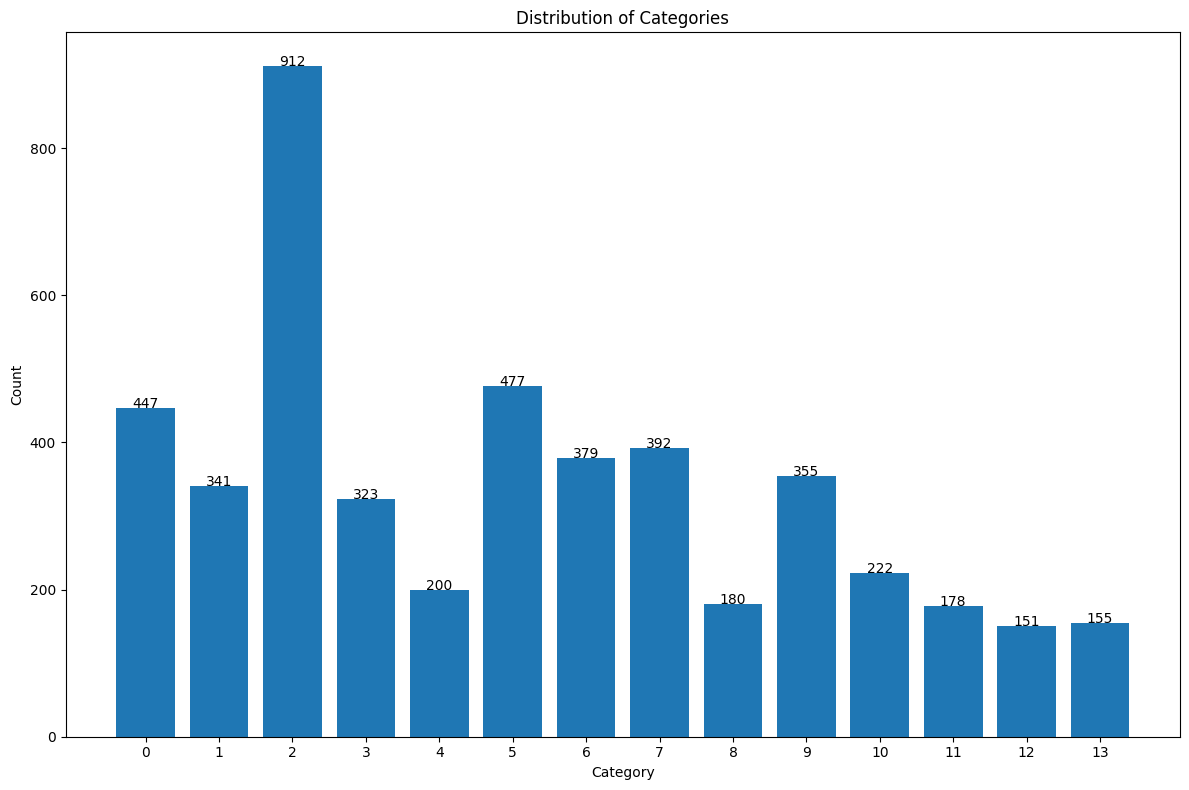

In [12]:
# 데이터 분포 확인

plot_distribution(preprocessed_articles)

In [13]:
# 훈련 데이터와 검증 데이터로 분리

train_articles, val_articles = train_test_split(
    preprocessed_articles,
    test_size=0.2,
    random_state=SEED
)

print(f'Number of training articles: {len(train_articles)}')
print(f'Number of validation articles: {len(val_articles)}')

Number of training articles: 3769
Number of validation articles: 943


자유 [0]: 9.07%
학사 [1]: 7.38%
장학 · 행정 [2]: 19.34%
학교생활 [3]: 6.90%
수업 [4]: 4.62%
수업/이과 [5]: 10.00%
수업/문과 [6]: 8.36%
캠퍼스 [7]: 8.12%
취업 · 진로 [8]: 3.79%
일상생활 [9]: 7.54%
음식점 · 카페 [10]: 4.59%
취미 · 여가 [11]: 3.87%
인간관계 [12]: 3.18%
병역 [13]: 3.24%


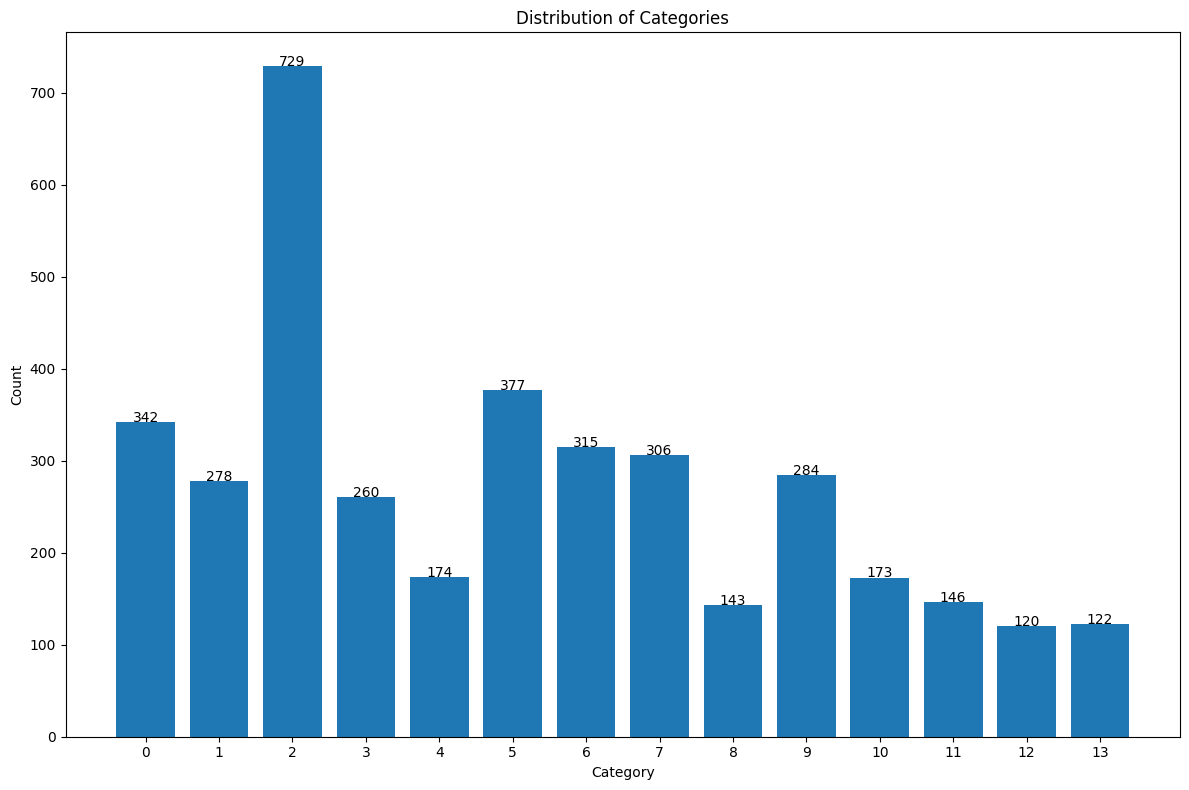

In [14]:
# 훈련 데이터의 데이터 분포 확인

plot_distribution(train_articles)

자유 [0]: 11.13%
학사 [1]: 6.68%
장학 · 행정 [2]: 19.41%
학교생활 [3]: 6.68%
수업 [4]: 2.76%
수업/이과 [5]: 10.60%
수업/문과 [6]: 6.79%
캠퍼스 [7]: 9.12%
취업 · 진로 [8]: 3.92%
일상생활 [9]: 7.53%
음식점 · 카페 [10]: 5.20%
취미 · 여가 [11]: 3.39%
인간관계 [12]: 3.29%
병역 [13]: 3.50%


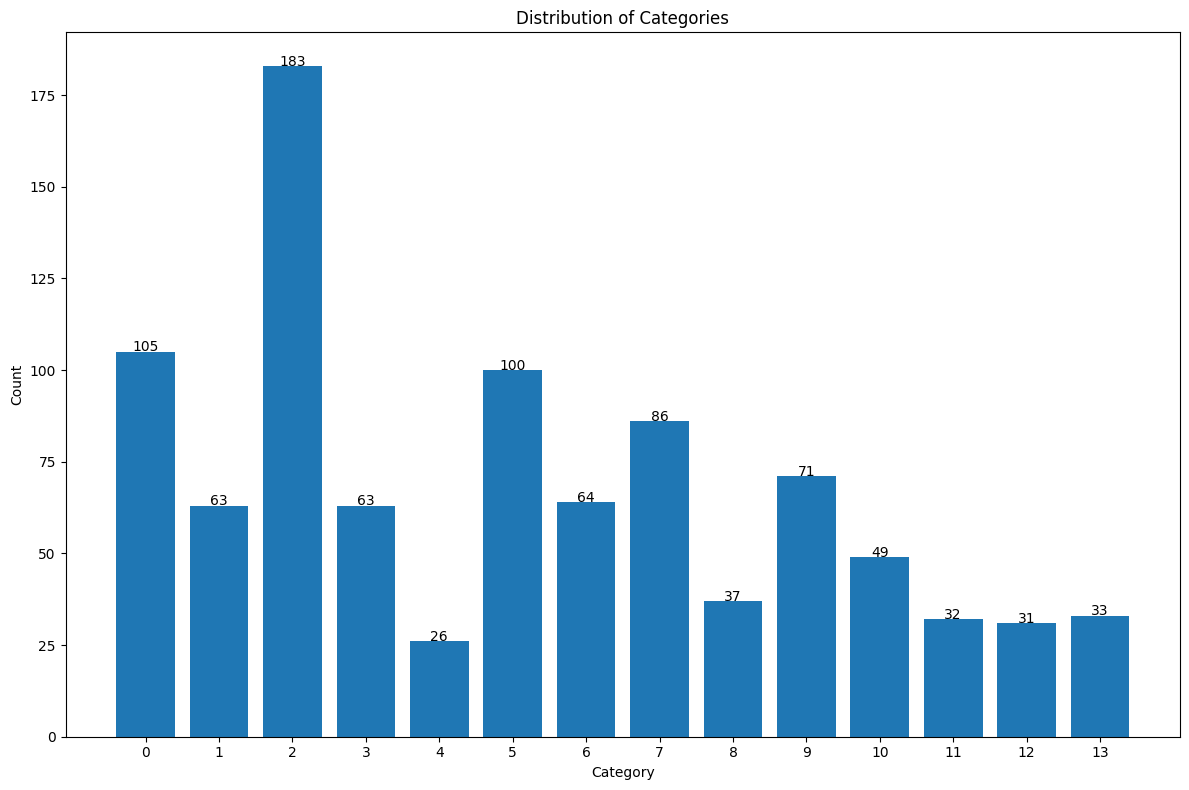

In [15]:
# 검증 데이터의 데이터 분포 확인

plot_distribution(val_articles)

In [16]:
# 토크나이저 로드

tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_ID, do_basic_tokenize=False)

print('Original:', preprocessed_articles[0]['content'])
print('Tokenized:', tokenizer.tokenize(preprocessed_articles[0]['content']))

Original: 어제 비마관 화장실에서 핸드폰 찾아주신분! 제가 경황이 없어서 감사하다고도 못 했네요. 정말 감사합니다!!!
Tokenized: ['어제', '비', '##마', '##관', '화장실', '##에서', '핸드폰', '찾아', '##주신', '##분', '!', '제가', '경', '##황', '##이', '없어서', '감사', '##하다고', '##도', '못', '했네요', '.', '정말', '감사합니다', '!', '!', '!']


In [17]:
# 텍스트 인코딩 및 데이터셋 생성

train_contents = [article['content'] for article in train_articles]
train_labels = [article['label'] for article in train_articles]
val_contents = [article['content'] for article in val_articles]
val_labels = [article['label'] for article in val_articles]

train_encodings = tokenizer(
    train_contents,
    padding=True,
    truncation=True,
    return_tensors='pt',
    max_length=MAX_LENGTH
)
val_encodings = tokenizer(
    val_contents,
    padding=True,
    truncation=True,
    return_tensors='pt',
    max_length=MAX_LENGTH
)

train_dataset = torch.utils.data.TensorDataset(
    torch.tensor(train_encodings['input_ids']),
    torch.tensor(train_encodings['attention_mask']),
    torch.tensor(train_labels)
)
val_dataset = torch.utils.data.TensorDataset(
    torch.tensor(val_encodings['input_ids']),
    torch.tensor(val_encodings['attention_mask']),
    torch.tensor(val_labels)
)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

/tmp/ipykernel_790634/2848816050.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(train_encodings['input_ids']),
/tmp/ipykernel_790634/2848816050.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(train_encodings['attention_mask']),
/tmp/ipykernel_790634/2848816050.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(val_encodings['input_ids']),
/tmp/ipykernel_790634/2848816050.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceT

In [18]:
# 평가 지표 계산 함수 정의

def calculate_metrics(true_labels, predicted_labels):
    acc = accuracy_score(true_labels, predicted_labels)
    prec = precision_score(true_labels, predicted_labels, average=METRIC_AVERAGE, zero_division=METRIC_ZERO_DIVISION)
    rec = recall_score(true_labels, predicted_labels, average=METRIC_AVERAGE, zero_division=METRIC_ZERO_DIVISION)
    f1 = f1_score(true_labels, predicted_labels, average=METRIC_AVERAGE, zero_division=METRIC_ZERO_DIVISION)

    return acc, prec, rec, f1

In [19]:
# 테스트 데이터셋 평가 함수 정의

with open('../test-dataset.json', 'r', encoding='utf-8') as f:
    test_articles = json.load(f)

test_contents = [preprocess(article['content']) for article in test_articles]
test_labels = [article['label'] for article in test_articles]

test_encodings = tokenizer(
    test_contents,
    padding=True,
    truncation=True,
    return_tensors='pt',
    max_length=MAX_LENGTH
)
test_input_ids = test_encodings['input_ids'].to(device)
test_attention_mask = test_encodings['attention_mask'].to(device)

def evaluate_test_dataset(model):
    model.eval()

    with torch.no_grad():
        outputs = model(test_input_ids, attention_mask=test_attention_mask)
        logits = outputs.logits
        test_predictions = torch.argmax(logits, dim=1).tolist()

    return calculate_metrics(test_labels, test_predictions)

In [20]:
# 학습 시작

best_val_f1 = 0.0
best_model_path = None
iteration = 0

while True:
    print(f'Iteration {iteration}')

    model = AutoModelForSequenceClassification.from_pretrained(MODEL_ID, num_labels=NUM_LABELS)
    model.to(device)
    model.resize_token_embeddings(len(tokenizer))

    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    total_steps = len(train_dataset) * EPOCHS
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    for epoch in range(EPOCHS):
        model.train()

        train_loss = 0.0
        train_predictions = []
        train_labels_epoch = []

        for batch in tqdm(train_dataloader, desc=f'Epoch {epoch + 1} - Training'):
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
            scheduler.step()
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1)

            train_predictions.extend(predictions.tolist())
            train_labels_epoch.extend(labels.tolist())

        train_acc, train_prec, train_rec, train_f1 = calculate_metrics(train_labels_epoch, train_predictions)
        train_loss /= len(train_dataloader)

        model.eval()

        val_loss = 0.0
        val_predictions = []

        with torch.no_grad():
            for batch in tqdm(val_dataloader, desc=f'Epoch {epoch + 1} - Validation'):
                input_ids = batch[0].to(device)
                attention_mask = batch[1].to(device)
                labels = batch[2].to(device)

                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                val_loss += loss.item()
                logits = outputs.logits
                predictions = torch.argmax(logits, dim=1)

                val_predictions.extend(predictions.tolist())

        val_acc, val_prec, val_rec, val_f1 = calculate_metrics(val_labels, val_predictions)
        val_loss /= len(val_dataloader)

        print(f'Epoch {epoch + 1}:')
        print(f'  Train Acc = {train_acc:.4f}, Train Prec = {train_prec:.4f}, Train Rec = {train_rec:.4f}, Train F1 = {train_f1:.4f}, Train Loss = {train_loss:.4f}')
        print(f'  Val Acc = {val_acc:.4f}, Val Prec = {val_prec:.4f}, Val Rec = {val_rec:.4f}, Val F1 = {val_f1:.4f}, Val Loss = {val_loss:.4f}')

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_model_path = os.path.join(SAVE_PATH, f'.model-iteration-{iteration + 1:02d}-epoch-{epoch + 1:02d}-{best_val_f1:.4f}')
            model.save_pretrained(best_model_path)
            tokenizer.save_pretrained(best_model_path)
            test_acc, test_prec, test_rec, test_f1 = evaluate_test_dataset(model)

            with open(os.path.join(best_model_path, 'metrics.txt'), 'w', encoding='utf-8') as f:
                f.write(f'Train Acc = {train_acc:.4f}, Train Prec = {train_prec:.4f}, Train Rec = {train_rec:.4f}, Train F1 = {train_f1:.4f}, Train Loss = {train_loss:.4f}\n')
                f.write(f'Val Acc = {val_acc:.4f}, Val Prec = {val_prec:.4f}, Val Rec = {val_rec:.4f}, Val F1 = {val_f1:.4f}, Val Loss = {val_loss:.4f}\n')
                f.write(f'Test Acc = {test_acc:.4f}, Test Prec = {test_prec:.4f}, Test Rec = {test_rec:.4f}, Test F1 = {test_f1:.4f}\n')

            print(f'  Best model saved with {best_val_f1:.4f} F1 score.')

    iteration += 1

Iteration 0


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.69it/s]


Epoch 1:
  Train Acc = 0.2993, Train Prec = 0.3049, Train Rec = 0.2993, Train F1 = 0.2107, Train Loss = 2.2806
  Val Acc = 0.5186, Val Prec = 0.3764, Val Rec = 0.5186, Val F1 = 0.4177, Val Loss = 1.6753
  Best model saved with 0.4177 F1 score.


Epoch 2 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.63it/s]


Epoch 2:
  Train Acc = 0.6278, Train Prec = 0.6814, Train Rec = 0.6278, Train F1 = 0.5760, Train Loss = 1.3190
  Val Acc = 0.7943, Val Prec = 0.8190, Val Rec = 0.7943, Val F1 = 0.7733, Val Loss = 0.8687
  Best model saved with 0.7733 F1 score.


Epoch 3 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.64it/s]


Epoch 3:
  Train Acc = 0.8554, Train Prec = 0.8627, Train Rec = 0.8554, Train F1 = 0.8488, Train Loss = 0.6756
  Val Acc = 0.9067, Val Prec = 0.9111, Val Rec = 0.9067, Val F1 = 0.9073, Val Loss = 0.4412
  Best model saved with 0.9073 F1 score.


Epoch 4 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.58it/s]


Epoch 4:
  Train Acc = 0.9443, Train Prec = 0.9443, Train Rec = 0.9443, Train F1 = 0.9441, Train Loss = 0.3142
  Val Acc = 0.9183, Val Prec = 0.9248, Val Rec = 0.9183, Val F1 = 0.9192, Val Loss = 0.3327
  Best model saved with 0.9192 F1 score.


Epoch 5 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.63it/s]


Epoch 5:
  Train Acc = 0.9748, Train Prec = 0.9749, Train Rec = 0.9748, Train F1 = 0.9748, Train Loss = 0.1582
  Val Acc = 0.9215, Val Prec = 0.9282, Val Rec = 0.9215, Val F1 = 0.9227, Val Loss = 0.3122
  Best model saved with 0.9227 F1 score.


Epoch 6 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.65it/s]


Epoch 6:
  Train Acc = 0.9838, Train Prec = 0.9838, Train Rec = 0.9838, Train F1 = 0.9838, Train Loss = 0.0949
  Val Acc = 0.9374, Val Prec = 0.9418, Val Rec = 0.9374, Val F1 = 0.9378, Val Loss = 0.2804
  Best model saved with 0.9378 F1 score.


Epoch 7 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.64it/s]


Epoch 7:
  Train Acc = 0.9883, Train Prec = 0.9883, Train Rec = 0.9883, Train F1 = 0.9883, Train Loss = 0.0635
  Val Acc = 0.9343, Val Prec = 0.9373, Val Rec = 0.9343, Val F1 = 0.9348, Val Loss = 0.2622


Epoch 8 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.66it/s]


Epoch 8:
  Train Acc = 0.9958, Train Prec = 0.9958, Train Rec = 0.9958, Train F1 = 0.9958, Train Loss = 0.0334
  Val Acc = 0.9353, Val Prec = 0.9405, Val Rec = 0.9353, Val F1 = 0.9358, Val Loss = 0.3050


Epoch 9 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.61it/s]


Epoch 9:
  Train Acc = 0.9971, Train Prec = 0.9971, Train Rec = 0.9971, Train F1 = 0.9971, Train Loss = 0.0255
  Val Acc = 0.9290, Val Prec = 0.9351, Val Rec = 0.9290, Val F1 = 0.9301, Val Loss = 0.3030


Epoch 10 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.61it/s]


Epoch 10:
  Train Acc = 0.9934, Train Prec = 0.9934, Train Rec = 0.9934, Train F1 = 0.9934, Train Loss = 0.0325
  Val Acc = 0.9364, Val Prec = 0.9388, Val Rec = 0.9364, Val F1 = 0.9364, Val Loss = 0.3118


Epoch 11 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.63it/s]


Epoch 11:
  Train Acc = 0.9966, Train Prec = 0.9966, Train Rec = 0.9966, Train F1 = 0.9966, Train Loss = 0.0227
  Val Acc = 0.9385, Val Prec = 0.9396, Val Rec = 0.9385, Val F1 = 0.9385, Val Loss = 0.2981
  Best model saved with 0.9385 F1 score.


Epoch 12 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.62it/s]


Epoch 12:
  Train Acc = 0.9992, Train Prec = 0.9992, Train Rec = 0.9992, Train F1 = 0.9992, Train Loss = 0.0100
  Val Acc = 0.9374, Val Prec = 0.9394, Val Rec = 0.9374, Val F1 = 0.9376, Val Loss = 0.3245


Epoch 13 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.67it/s]


Epoch 13:
  Train Acc = 0.9923, Train Prec = 0.9923, Train Rec = 0.9923, Train F1 = 0.9923, Train Loss = 0.0334
  Val Acc = 0.9236, Val Prec = 0.9265, Val Rec = 0.9236, Val F1 = 0.9235, Val Loss = 0.4039


Epoch 14 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.64it/s]


Epoch 14:
  Train Acc = 0.9915, Train Prec = 0.9915, Train Rec = 0.9915, Train F1 = 0.9915, Train Loss = 0.0385
  Val Acc = 0.9353, Val Prec = 0.9383, Val Rec = 0.9353, Val F1 = 0.9356, Val Loss = 0.3406


Epoch 15 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.61it/s]


Epoch 15:
  Train Acc = 0.9952, Train Prec = 0.9952, Train Rec = 0.9952, Train F1 = 0.9952, Train Loss = 0.0202
  Val Acc = 0.9321, Val Prec = 0.9329, Val Rec = 0.9321, Val F1 = 0.9320, Val Loss = 0.3726


Epoch 16 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.64it/s]


Epoch 16:
  Train Acc = 0.9944, Train Prec = 0.9944, Train Rec = 0.9944, Train F1 = 0.9944, Train Loss = 0.0247
  Val Acc = 0.9385, Val Prec = 0.9408, Val Rec = 0.9385, Val F1 = 0.9386, Val Loss = 0.3512
  Best model saved with 0.9386 F1 score.


Epoch 17 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.67it/s]


Epoch 17:
  Train Acc = 0.9973, Train Prec = 0.9974, Train Rec = 0.9973, Train F1 = 0.9973, Train Loss = 0.0164
  Val Acc = 0.9353, Val Prec = 0.9373, Val Rec = 0.9353, Val F1 = 0.9353, Val Loss = 0.3442


Epoch 18 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.65it/s]


Epoch 18:
  Train Acc = 0.9939, Train Prec = 0.9939, Train Rec = 0.9939, Train F1 = 0.9939, Train Loss = 0.0231
  Val Acc = 0.9343, Val Prec = 0.9345, Val Rec = 0.9343, Val F1 = 0.9340, Val Loss = 0.3406


Epoch 19 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.64it/s]


Epoch 19:
  Train Acc = 0.9976, Train Prec = 0.9976, Train Rec = 0.9976, Train F1 = 0.9976, Train Loss = 0.0142
  Val Acc = 0.9332, Val Prec = 0.9367, Val Rec = 0.9332, Val F1 = 0.9333, Val Loss = 0.4034


Epoch 20 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.65it/s]


Epoch 20:
  Train Acc = 0.9989, Train Prec = 0.9989, Train Rec = 0.9989, Train F1 = 0.9989, Train Loss = 0.0072
  Val Acc = 0.9438, Val Prec = 0.9445, Val Rec = 0.9438, Val F1 = 0.9438, Val Loss = 0.3179
  Best model saved with 0.9438 F1 score.
Iteration 1


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.64it/s]


Epoch 1:
  Train Acc = 0.2361, Train Prec = 0.1124, Train Rec = 0.2361, Train F1 = 0.1252, Train Loss = 2.4061
  Val Acc = 0.3807, Val Prec = 0.2385, Val Rec = 0.3807, Val F1 = 0.2477, Val Loss = 2.0546


Epoch 2 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.64it/s]


Epoch 2:
  Train Acc = 0.4797, Train Prec = 0.4061, Train Rec = 0.4797, Train F1 = 0.3853, Train Loss = 1.7145
  Val Acc = 0.6288, Val Prec = 0.5865, Val Rec = 0.6288, Val F1 = 0.5714, Val Loss = 1.2323


Epoch 3 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.65it/s]


Epoch 3:
  Train Acc = 0.7150, Train Prec = 0.7355, Train Rec = 0.7150, Train F1 = 0.6899, Train Loss = 1.0362
  Val Acc = 0.8431, Val Prec = 0.8759, Val Rec = 0.8431, Val F1 = 0.8316, Val Loss = 0.6891


Epoch 4 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.68it/s]


Epoch 4:
  Train Acc = 0.9000, Train Prec = 0.9002, Train Rec = 0.9000, Train F1 = 0.8980, Train Loss = 0.5216
  Val Acc = 0.8971, Val Prec = 0.9069, Val Rec = 0.8971, Val F1 = 0.8962, Val Loss = 0.4331


Epoch 5 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.66it/s]


Epoch 5:
  Train Acc = 0.9565, Train Prec = 0.9566, Train Rec = 0.9565, Train F1 = 0.9564, Train Loss = 0.2442
  Val Acc = 0.9311, Val Prec = 0.9353, Val Rec = 0.9311, Val F1 = 0.9319, Val Loss = 0.2861


Epoch 6 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.67it/s]


Epoch 6:
  Train Acc = 0.9790, Train Prec = 0.9792, Train Rec = 0.9790, Train F1 = 0.9791, Train Loss = 0.1337
  Val Acc = 0.9311, Val Prec = 0.9335, Val Rec = 0.9311, Val F1 = 0.9308, Val Loss = 0.2841


Epoch 7 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.68it/s]


Epoch 7:
  Train Acc = 0.9928, Train Prec = 0.9929, Train Rec = 0.9928, Train F1 = 0.9928, Train Loss = 0.0676
  Val Acc = 0.9364, Val Prec = 0.9392, Val Rec = 0.9364, Val F1 = 0.9364, Val Loss = 0.2685


Epoch 8 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.68it/s]


Epoch 8:
  Train Acc = 0.9973, Train Prec = 0.9974, Train Rec = 0.9973, Train F1 = 0.9973, Train Loss = 0.0382
  Val Acc = 0.9427, Val Prec = 0.9444, Val Rec = 0.9427, Val F1 = 0.9428, Val Loss = 0.2619


Epoch 9 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.66it/s]


Epoch 9:
  Train Acc = 0.9989, Train Prec = 0.9989, Train Rec = 0.9989, Train F1 = 0.9989, Train Loss = 0.0237
  Val Acc = 0.9374, Val Prec = 0.9384, Val Rec = 0.9374, Val F1 = 0.9375, Val Loss = 0.2828


Epoch 10 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.67it/s]


Epoch 10:
  Train Acc = 0.9881, Train Prec = 0.9881, Train Rec = 0.9881, Train F1 = 0.9881, Train Loss = 0.0561
  Val Acc = 0.9247, Val Prec = 0.9292, Val Rec = 0.9247, Val F1 = 0.9256, Val Loss = 0.3171


Epoch 11 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.67it/s]


Epoch 11:
  Train Acc = 0.9928, Train Prec = 0.9928, Train Rec = 0.9928, Train F1 = 0.9928, Train Loss = 0.0356
  Val Acc = 0.9417, Val Prec = 0.9439, Val Rec = 0.9417, Val F1 = 0.9418, Val Loss = 0.2760


Epoch 12 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.69it/s]


Epoch 12:
  Train Acc = 0.9976, Train Prec = 0.9976, Train Rec = 0.9976, Train F1 = 0.9976, Train Loss = 0.0180
  Val Acc = 0.9385, Val Prec = 0.9415, Val Rec = 0.9385, Val F1 = 0.9388, Val Loss = 0.2909


Epoch 13 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.67it/s]


Epoch 13:
  Train Acc = 0.9939, Train Prec = 0.9939, Train Rec = 0.9939, Train F1 = 0.9939, Train Loss = 0.0339
  Val Acc = 0.9385, Val Prec = 0.9411, Val Rec = 0.9385, Val F1 = 0.9383, Val Loss = 0.3207


Epoch 14 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.66it/s]


Epoch 14:
  Train Acc = 0.9947, Train Prec = 0.9947, Train Rec = 0.9947, Train F1 = 0.9947, Train Loss = 0.0316
  Val Acc = 0.9343, Val Prec = 0.9373, Val Rec = 0.9343, Val F1 = 0.9347, Val Loss = 0.3058


Epoch 15 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.66it/s]


Epoch 15:
  Train Acc = 0.9963, Train Prec = 0.9963, Train Rec = 0.9963, Train F1 = 0.9963, Train Loss = 0.0177
  Val Acc = 0.9332, Val Prec = 0.9355, Val Rec = 0.9332, Val F1 = 0.9331, Val Loss = 0.3444


Epoch 16 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.68it/s]


Epoch 16:
  Train Acc = 0.9963, Train Prec = 0.9963, Train Rec = 0.9963, Train F1 = 0.9963, Train Loss = 0.0211
  Val Acc = 0.9417, Val Prec = 0.9434, Val Rec = 0.9417, Val F1 = 0.9416, Val Loss = 0.2971


Epoch 17 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.66it/s]


Epoch 17:
  Train Acc = 0.9981, Train Prec = 0.9981, Train Rec = 0.9981, Train F1 = 0.9981, Train Loss = 0.0098
  Val Acc = 0.9438, Val Prec = 0.9462, Val Rec = 0.9438, Val F1 = 0.9440, Val Loss = 0.3103
  Best model saved with 0.9440 F1 score.


Epoch 18 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.67it/s]


Epoch 18:
  Train Acc = 0.9995, Train Prec = 0.9995, Train Rec = 0.9995, Train F1 = 0.9995, Train Loss = 0.0083
  Val Acc = 0.9470, Val Prec = 0.9484, Val Rec = 0.9470, Val F1 = 0.9469, Val Loss = 0.2953
  Best model saved with 0.9469 F1 score.


Epoch 19 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.69it/s]


Epoch 19:
  Train Acc = 0.9981, Train Prec = 0.9981, Train Rec = 0.9981, Train F1 = 0.9981, Train Loss = 0.0081
  Val Acc = 0.9364, Val Prec = 0.9385, Val Rec = 0.9364, Val F1 = 0.9364, Val Loss = 0.2988


Epoch 20 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.67it/s]


Epoch 20:
  Train Acc = 0.9690, Train Prec = 0.9692, Train Rec = 0.9690, Train F1 = 0.9690, Train Loss = 0.1141
  Val Acc = 0.9374, Val Prec = 0.9377, Val Rec = 0.9374, Val F1 = 0.9369, Val Loss = 0.2949
Iteration 2


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.69it/s]


Epoch 1:
  Train Acc = 0.2810, Train Prec = 0.2062, Train Rec = 0.2810, Train F1 = 0.1822, Train Loss = 2.3125
  Val Acc = 0.4602, Val Prec = 0.4128, Val Rec = 0.4602, Val F1 = 0.3500, Val Loss = 1.7760


Epoch 2 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.70it/s]


Epoch 2:
  Train Acc = 0.5837, Train Prec = 0.6220, Train Rec = 0.5837, Train F1 = 0.5172, Train Loss = 1.4351
  Val Acc = 0.7359, Val Prec = 0.7407, Val Rec = 0.7359, Val F1 = 0.6932, Val Loss = 0.9876


Epoch 3 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.68it/s]


Epoch 3:
  Train Acc = 0.8188, Train Prec = 0.8291, Train Rec = 0.8188, Train F1 = 0.8049, Train Loss = 0.7790
  Val Acc = 0.8887, Val Prec = 0.9002, Val Rec = 0.8887, Val F1 = 0.8877, Val Loss = 0.5108


Epoch 4 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.70it/s]


Epoch 4:
  Train Acc = 0.9480, Train Prec = 0.9483, Train Rec = 0.9480, Train F1 = 0.9477, Train Loss = 0.3424
  Val Acc = 0.9130, Val Prec = 0.9169, Val Rec = 0.9130, Val F1 = 0.9131, Val Loss = 0.3421


Epoch 5 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.67it/s]


Epoch 5:
  Train Acc = 0.9767, Train Prec = 0.9767, Train Rec = 0.9767, Train F1 = 0.9767, Train Loss = 0.1643
  Val Acc = 0.9236, Val Prec = 0.9253, Val Rec = 0.9236, Val F1 = 0.9231, Val Loss = 0.3205


Epoch 6 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.71it/s]


Epoch 6:
  Train Acc = 0.9870, Train Prec = 0.9870, Train Rec = 0.9870, Train F1 = 0.9870, Train Loss = 0.0908
  Val Acc = 0.9311, Val Prec = 0.9343, Val Rec = 0.9311, Val F1 = 0.9314, Val Loss = 0.2963


Epoch 7 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.68it/s]


Epoch 7:
  Train Acc = 0.9934, Train Prec = 0.9934, Train Rec = 0.9934, Train F1 = 0.9934, Train Loss = 0.0557
  Val Acc = 0.9300, Val Prec = 0.9360, Val Rec = 0.9300, Val F1 = 0.9305, Val Loss = 0.3144


Epoch 8 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.69it/s]


Epoch 8:
  Train Acc = 0.9939, Train Prec = 0.9939, Train Rec = 0.9939, Train F1 = 0.9939, Train Loss = 0.0413
  Val Acc = 0.9332, Val Prec = 0.9360, Val Rec = 0.9332, Val F1 = 0.9337, Val Loss = 0.2826


Epoch 9 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.68it/s]


Epoch 9:
  Train Acc = 0.9950, Train Prec = 0.9950, Train Rec = 0.9950, Train F1 = 0.9950, Train Loss = 0.0329
  Val Acc = 0.9374, Val Prec = 0.9410, Val Rec = 0.9374, Val F1 = 0.9379, Val Loss = 0.2900


Epoch 10 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.68it/s]


Epoch 10:
  Train Acc = 0.9981, Train Prec = 0.9981, Train Rec = 0.9981, Train F1 = 0.9981, Train Loss = 0.0220
  Val Acc = 0.9438, Val Prec = 0.9456, Val Rec = 0.9438, Val F1 = 0.9440, Val Loss = 0.2542


Epoch 11 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.66it/s]


Epoch 11:
  Train Acc = 0.9952, Train Prec = 0.9952, Train Rec = 0.9952, Train F1 = 0.9952, Train Loss = 0.0233
  Val Acc = 0.9300, Val Prec = 0.9366, Val Rec = 0.9300, Val F1 = 0.9309, Val Loss = 0.3265


Epoch 12 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.67it/s]


Epoch 12:
  Train Acc = 0.9915, Train Prec = 0.9915, Train Rec = 0.9915, Train F1 = 0.9915, Train Loss = 0.0449
  Val Acc = 0.9364, Val Prec = 0.9398, Val Rec = 0.9364, Val F1 = 0.9370, Val Loss = 0.2973


Epoch 13 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.68it/s]


Epoch 13:
  Train Acc = 0.9952, Train Prec = 0.9952, Train Rec = 0.9952, Train F1 = 0.9952, Train Loss = 0.0265
  Val Acc = 0.9427, Val Prec = 0.9462, Val Rec = 0.9427, Val F1 = 0.9429, Val Loss = 0.2906


Epoch 14 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.68it/s]


Epoch 14:
  Train Acc = 0.9966, Train Prec = 0.9966, Train Rec = 0.9966, Train F1 = 0.9966, Train Loss = 0.0191
  Val Acc = 0.9438, Val Prec = 0.9465, Val Rec = 0.9438, Val F1 = 0.9440, Val Loss = 0.2698


Epoch 15 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.68it/s]


Epoch 15:
  Train Acc = 0.9926, Train Prec = 0.9926, Train Rec = 0.9926, Train F1 = 0.9926, Train Loss = 0.0324
  Val Acc = 0.9396, Val Prec = 0.9417, Val Rec = 0.9396, Val F1 = 0.9392, Val Loss = 0.2840


Epoch 16 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.68it/s]


Epoch 16:
  Train Acc = 0.9968, Train Prec = 0.9968, Train Rec = 0.9968, Train F1 = 0.9968, Train Loss = 0.0161
  Val Acc = 0.9427, Val Prec = 0.9450, Val Rec = 0.9427, Val F1 = 0.9426, Val Loss = 0.3109


Epoch 17 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.68it/s]


Epoch 17:
  Train Acc = 0.9995, Train Prec = 0.9995, Train Rec = 0.9995, Train F1 = 0.9995, Train Loss = 0.0056
  Val Acc = 0.9438, Val Prec = 0.9448, Val Rec = 0.9438, Val F1 = 0.9435, Val Loss = 0.2894


Epoch 18 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.67it/s]


Epoch 18:
  Train Acc = 0.9987, Train Prec = 0.9987, Train Rec = 0.9987, Train F1 = 0.9987, Train Loss = 0.0088
  Val Acc = 0.9470, Val Prec = 0.9485, Val Rec = 0.9470, Val F1 = 0.9467, Val Loss = 0.2935


Epoch 19 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.68it/s]


Epoch 19:
  Train Acc = 0.9971, Train Prec = 0.9971, Train Rec = 0.9971, Train F1 = 0.9971, Train Loss = 0.0143
  Val Acc = 0.9247, Val Prec = 0.9312, Val Rec = 0.9247, Val F1 = 0.9250, Val Loss = 0.4348


Epoch 20 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.69it/s]


Epoch 20:
  Train Acc = 0.9955, Train Prec = 0.9955, Train Rec = 0.9955, Train F1 = 0.9955, Train Loss = 0.0175
  Val Acc = 0.9374, Val Prec = 0.9399, Val Rec = 0.9374, Val F1 = 0.9373, Val Loss = 0.3828
Iteration 3


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.67it/s]


Epoch 1:
  Train Acc = 0.2775, Train Prec = 0.1705, Train Rec = 0.2775, Train F1 = 0.1668, Train Loss = 2.3105
  Val Acc = 0.4846, Val Prec = 0.3622, Val Rec = 0.4846, Val F1 = 0.3494, Val Loss = 1.7937


Epoch 2 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.68it/s]


Epoch 2:
  Train Acc = 0.5641, Train Prec = 0.6554, Train Rec = 0.5641, Train F1 = 0.4991, Train Loss = 1.4443
  Val Acc = 0.7306, Val Prec = 0.7013, Val Rec = 0.7306, Val F1 = 0.6876, Val Loss = 0.9726


Epoch 3 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.68it/s]


Epoch 3:
  Train Acc = 0.8413, Train Prec = 0.8543, Train Rec = 0.8413, Train F1 = 0.8277, Train Loss = 0.7432
  Val Acc = 0.8547, Val Prec = 0.8741, Val Rec = 0.8547, Val F1 = 0.8423, Val Loss = 0.5608


Epoch 4 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.68it/s]


Epoch 4:
  Train Acc = 0.9363, Train Prec = 0.9373, Train Rec = 0.9363, Train F1 = 0.9356, Train Loss = 0.3539
  Val Acc = 0.9300, Val Prec = 0.9324, Val Rec = 0.9300, Val F1 = 0.9301, Val Loss = 0.3120


Epoch 5 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.68it/s]


Epoch 5:
  Train Acc = 0.9769, Train Prec = 0.9771, Train Rec = 0.9769, Train F1 = 0.9769, Train Loss = 0.1658
  Val Acc = 0.9279, Val Prec = 0.9322, Val Rec = 0.9279, Val F1 = 0.9286, Val Loss = 0.2651


Epoch 6 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.67it/s]


Epoch 6:
  Train Acc = 0.9851, Train Prec = 0.9851, Train Rec = 0.9851, Train F1 = 0.9851, Train Loss = 0.1021
  Val Acc = 0.9279, Val Prec = 0.9316, Val Rec = 0.9279, Val F1 = 0.9279, Val Loss = 0.2982


Epoch 7 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.66it/s]


Epoch 7:
  Train Acc = 0.9936, Train Prec = 0.9937, Train Rec = 0.9936, Train F1 = 0.9936, Train Loss = 0.0541
  Val Acc = 0.9364, Val Prec = 0.9391, Val Rec = 0.9364, Val F1 = 0.9367, Val Loss = 0.2827


Epoch 8 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.65it/s]


Epoch 8:
  Train Acc = 0.9947, Train Prec = 0.9947, Train Rec = 0.9947, Train F1 = 0.9947, Train Loss = 0.0405
  Val Acc = 0.9396, Val Prec = 0.9418, Val Rec = 0.9396, Val F1 = 0.9397, Val Loss = 0.2722


Epoch 9 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.62it/s]


Epoch 9:
  Train Acc = 0.9958, Train Prec = 0.9958, Train Rec = 0.9958, Train F1 = 0.9958, Train Loss = 0.0347
  Val Acc = 0.9279, Val Prec = 0.9324, Val Rec = 0.9279, Val F1 = 0.9290, Val Loss = 0.3272


Epoch 10 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.63it/s]


Epoch 10:
  Train Acc = 0.9947, Train Prec = 0.9947, Train Rec = 0.9947, Train F1 = 0.9947, Train Loss = 0.0298
  Val Acc = 0.9406, Val Prec = 0.9434, Val Rec = 0.9406, Val F1 = 0.9406, Val Loss = 0.2952


Epoch 11 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.64it/s]


Epoch 11:
  Train Acc = 0.9976, Train Prec = 0.9976, Train Rec = 0.9976, Train F1 = 0.9976, Train Loss = 0.0185
  Val Acc = 0.9364, Val Prec = 0.9397, Val Rec = 0.9364, Val F1 = 0.9366, Val Loss = 0.3088


Epoch 12 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.65it/s]


Epoch 12:
  Train Acc = 0.9963, Train Prec = 0.9963, Train Rec = 0.9963, Train F1 = 0.9963, Train Loss = 0.0180
  Val Acc = 0.9396, Val Prec = 0.9408, Val Rec = 0.9396, Val F1 = 0.9394, Val Loss = 0.3093


Epoch 13 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.67it/s]


Epoch 13:
  Train Acc = 0.9936, Train Prec = 0.9937, Train Rec = 0.9936, Train F1 = 0.9936, Train Loss = 0.0299
  Val Acc = 0.9311, Val Prec = 0.9364, Val Rec = 0.9311, Val F1 = 0.9315, Val Loss = 0.3607


Epoch 14 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.66it/s]


Epoch 14:
  Train Acc = 0.9958, Train Prec = 0.9958, Train Rec = 0.9958, Train F1 = 0.9957, Train Loss = 0.0194
  Val Acc = 0.9077, Val Prec = 0.9156, Val Rec = 0.9077, Val F1 = 0.9087, Val Loss = 0.4484


Epoch 15 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.65it/s]


Epoch 15:
  Train Acc = 0.9936, Train Prec = 0.9936, Train Rec = 0.9936, Train F1 = 0.9936, Train Loss = 0.0239
  Val Acc = 0.9353, Val Prec = 0.9385, Val Rec = 0.9353, Val F1 = 0.9354, Val Loss = 0.3669


Epoch 16 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.61it/s]


Epoch 16:
  Train Acc = 0.9973, Train Prec = 0.9974, Train Rec = 0.9973, Train F1 = 0.9973, Train Loss = 0.0153
  Val Acc = 0.9321, Val Prec = 0.9359, Val Rec = 0.9321, Val F1 = 0.9324, Val Loss = 0.3897


Epoch 17 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.59it/s]


Epoch 17:
  Train Acc = 0.9981, Train Prec = 0.9981, Train Rec = 0.9981, Train F1 = 0.9981, Train Loss = 0.0144
  Val Acc = 0.9406, Val Prec = 0.9419, Val Rec = 0.9406, Val F1 = 0.9405, Val Loss = 0.3320


Epoch 18 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.64it/s]


Epoch 18:
  Train Acc = 0.9963, Train Prec = 0.9963, Train Rec = 0.9963, Train F1 = 0.9963, Train Loss = 0.0182
  Val Acc = 0.9353, Val Prec = 0.9381, Val Rec = 0.9353, Val F1 = 0.9352, Val Loss = 0.3728


Epoch 19 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.67it/s]


Epoch 19:
  Train Acc = 0.9942, Train Prec = 0.9942, Train Rec = 0.9942, Train F1 = 0.9942, Train Loss = 0.0266
  Val Acc = 0.9491, Val Prec = 0.9506, Val Rec = 0.9491, Val F1 = 0.9493, Val Loss = 0.3104
  Best model saved with 0.9493 F1 score.


Epoch 20 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.67it/s]


Epoch 20:
  Train Acc = 0.9947, Train Prec = 0.9947, Train Rec = 0.9947, Train F1 = 0.9947, Train Loss = 0.0237
  Val Acc = 0.9480, Val Prec = 0.9486, Val Rec = 0.9480, Val F1 = 0.9479, Val Loss = 0.2648
Iteration 4


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.66it/s]


Epoch 1:
  Train Acc = 0.2903, Train Prec = 0.2696, Train Rec = 0.2903, Train F1 = 0.1813, Train Loss = 2.2643
  Val Acc = 0.5037, Val Prec = 0.3366, Val Rec = 0.5037, Val F1 = 0.3880, Val Loss = 1.6825


Epoch 2 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.68it/s]


Epoch 2:
  Train Acc = 0.6025, Train Prec = 0.6193, Train Rec = 0.6025, Train F1 = 0.5433, Train Loss = 1.3539
  Val Acc = 0.7296, Val Prec = 0.7054, Val Rec = 0.7296, Val F1 = 0.6757, Val Loss = 0.8998


Epoch 3 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.70it/s]


Epoch 3:
  Train Acc = 0.8403, Train Prec = 0.8500, Train Rec = 0.8403, Train F1 = 0.8333, Train Loss = 0.7055
  Val Acc = 0.8929, Val Prec = 0.9001, Val Rec = 0.8929, Val F1 = 0.8936, Val Loss = 0.4838


Epoch 4 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.69it/s]


Epoch 4:
  Train Acc = 0.9522, Train Prec = 0.9525, Train Rec = 0.9522, Train F1 = 0.9522, Train Loss = 0.3063
  Val Acc = 0.9268, Val Prec = 0.9314, Val Rec = 0.9268, Val F1 = 0.9266, Val Loss = 0.3129


Epoch 5 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.67it/s]


Epoch 5:
  Train Acc = 0.9740, Train Prec = 0.9741, Train Rec = 0.9740, Train F1 = 0.9740, Train Loss = 0.1595
  Val Acc = 0.9279, Val Prec = 0.9307, Val Rec = 0.9279, Val F1 = 0.9280, Val Loss = 0.2766


Epoch 6 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.69it/s]


Epoch 6:
  Train Acc = 0.9854, Train Prec = 0.9854, Train Rec = 0.9854, Train F1 = 0.9854, Train Loss = 0.0922
  Val Acc = 0.9321, Val Prec = 0.9374, Val Rec = 0.9321, Val F1 = 0.9329, Val Loss = 0.2998


Epoch 7 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.70it/s]


Epoch 7:
  Train Acc = 0.9926, Train Prec = 0.9926, Train Rec = 0.9926, Train F1 = 0.9926, Train Loss = 0.0543
  Val Acc = 0.9343, Val Prec = 0.9380, Val Rec = 0.9343, Val F1 = 0.9346, Val Loss = 0.2946


Epoch 8 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.68it/s]


Epoch 8:
  Train Acc = 0.9944, Train Prec = 0.9944, Train Rec = 0.9944, Train F1 = 0.9944, Train Loss = 0.0369
  Val Acc = 0.9258, Val Prec = 0.9314, Val Rec = 0.9258, Val F1 = 0.9255, Val Loss = 0.3182


Epoch 9 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.67it/s]


Epoch 9:
  Train Acc = 0.9934, Train Prec = 0.9934, Train Rec = 0.9934, Train F1 = 0.9934, Train Loss = 0.0361
  Val Acc = 0.9236, Val Prec = 0.9271, Val Rec = 0.9236, Val F1 = 0.9240, Val Loss = 0.3326


Epoch 10 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.65it/s]


Epoch 10:
  Train Acc = 0.9928, Train Prec = 0.9929, Train Rec = 0.9928, Train F1 = 0.9928, Train Loss = 0.0346
  Val Acc = 0.9385, Val Prec = 0.9405, Val Rec = 0.9385, Val F1 = 0.9384, Val Loss = 0.2822


Epoch 11 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.63it/s]


Epoch 11:
  Train Acc = 0.9952, Train Prec = 0.9952, Train Rec = 0.9952, Train F1 = 0.9952, Train Loss = 0.0259
  Val Acc = 0.9417, Val Prec = 0.9436, Val Rec = 0.9417, Val F1 = 0.9416, Val Loss = 0.2977


Epoch 12 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.63it/s]


Epoch 12:
  Train Acc = 0.9968, Train Prec = 0.9968, Train Rec = 0.9968, Train F1 = 0.9968, Train Loss = 0.0241
  Val Acc = 0.9247, Val Prec = 0.9342, Val Rec = 0.9247, Val F1 = 0.9269, Val Loss = 0.3685


Epoch 13 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.62it/s]


Epoch 13:
  Train Acc = 0.9926, Train Prec = 0.9926, Train Rec = 0.9926, Train F1 = 0.9926, Train Loss = 0.0294
  Val Acc = 0.9332, Val Prec = 0.9369, Val Rec = 0.9332, Val F1 = 0.9338, Val Loss = 0.3445


Epoch 14 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.63it/s]


Epoch 14:
  Train Acc = 0.9958, Train Prec = 0.9958, Train Rec = 0.9958, Train F1 = 0.9958, Train Loss = 0.0199
  Val Acc = 0.9279, Val Prec = 0.9324, Val Rec = 0.9279, Val F1 = 0.9290, Val Loss = 0.3596


Epoch 15 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.67it/s]


Epoch 15:
  Train Acc = 0.9920, Train Prec = 0.9921, Train Rec = 0.9920, Train F1 = 0.9921, Train Loss = 0.0371
  Val Acc = 0.9406, Val Prec = 0.9423, Val Rec = 0.9406, Val F1 = 0.9407, Val Loss = 0.3094


Epoch 16 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.66it/s]


Epoch 16:
  Train Acc = 0.9955, Train Prec = 0.9955, Train Rec = 0.9955, Train F1 = 0.9955, Train Loss = 0.0184
  Val Acc = 0.9417, Val Prec = 0.9430, Val Rec = 0.9417, Val F1 = 0.9418, Val Loss = 0.3203


Epoch 17 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.65it/s]


Epoch 17:
  Train Acc = 0.9944, Train Prec = 0.9944, Train Rec = 0.9944, Train F1 = 0.9944, Train Loss = 0.0201
  Val Acc = 0.9427, Val Prec = 0.9433, Val Rec = 0.9427, Val F1 = 0.9427, Val Loss = 0.3098


Epoch 18 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.66it/s]


Epoch 18:
  Train Acc = 0.9958, Train Prec = 0.9958, Train Rec = 0.9958, Train F1 = 0.9958, Train Loss = 0.0181
  Val Acc = 0.9353, Val Prec = 0.9383, Val Rec = 0.9353, Val F1 = 0.9357, Val Loss = 0.3700


Epoch 19 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.64it/s]


Epoch 19:
  Train Acc = 0.9958, Train Prec = 0.9958, Train Rec = 0.9958, Train F1 = 0.9958, Train Loss = 0.0156
  Val Acc = 0.9438, Val Prec = 0.9447, Val Rec = 0.9438, Val F1 = 0.9438, Val Loss = 0.3434


Epoch 20 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.65it/s]


Epoch 20:
  Train Acc = 0.9979, Train Prec = 0.9979, Train Rec = 0.9979, Train F1 = 0.9979, Train Loss = 0.0089
  Val Acc = 0.9279, Val Prec = 0.9333, Val Rec = 0.9279, Val F1 = 0.9282, Val Loss = 0.4036
Iteration 5


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.66it/s]


Epoch 1:
  Train Acc = 0.2789, Train Prec = 0.2144, Train Rec = 0.2789, Train F1 = 0.1830, Train Loss = 2.2998
  Val Acc = 0.4698, Val Prec = 0.3591, Val Rec = 0.4698, Val F1 = 0.3454, Val Loss = 1.7408


Epoch 2 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.62it/s]


Epoch 2:
  Train Acc = 0.6025, Train Prec = 0.6353, Train Rec = 0.6025, Train F1 = 0.5407, Train Loss = 1.3386
  Val Acc = 0.7964, Val Prec = 0.8022, Val Rec = 0.7964, Val F1 = 0.7646, Val Loss = 0.8555


Epoch 3 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.63it/s]


Epoch 3:
  Train Acc = 0.8522, Train Prec = 0.8583, Train Rec = 0.8522, Train F1 = 0.8439, Train Loss = 0.6700
  Val Acc = 0.8982, Val Prec = 0.9125, Val Rec = 0.8982, Val F1 = 0.8977, Val Loss = 0.4787


Epoch 4 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.64it/s]


Epoch 4:
  Train Acc = 0.9451, Train Prec = 0.9452, Train Rec = 0.9451, Train F1 = 0.9450, Train Loss = 0.3124
  Val Acc = 0.9099, Val Prec = 0.9184, Val Rec = 0.9099, Val F1 = 0.9110, Val Loss = 0.3307


Epoch 5 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.64it/s]


Epoch 5:
  Train Acc = 0.9719, Train Prec = 0.9719, Train Rec = 0.9719, Train F1 = 0.9719, Train Loss = 0.1678
  Val Acc = 0.9353, Val Prec = 0.9373, Val Rec = 0.9353, Val F1 = 0.9356, Val Loss = 0.2792


Epoch 6 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.68it/s]


Epoch 6:
  Train Acc = 0.9857, Train Prec = 0.9857, Train Rec = 0.9857, Train F1 = 0.9857, Train Loss = 0.0942
  Val Acc = 0.9300, Val Prec = 0.9342, Val Rec = 0.9300, Val F1 = 0.9305, Val Loss = 0.2836


Epoch 7 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.66it/s]


Epoch 7:
  Train Acc = 0.9891, Train Prec = 0.9892, Train Rec = 0.9891, Train F1 = 0.9891, Train Loss = 0.0652
  Val Acc = 0.9364, Val Prec = 0.9398, Val Rec = 0.9364, Val F1 = 0.9364, Val Loss = 0.2835


Epoch 8 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.65it/s]


Epoch 8:
  Train Acc = 0.9950, Train Prec = 0.9950, Train Rec = 0.9950, Train F1 = 0.9950, Train Loss = 0.0371
  Val Acc = 0.9396, Val Prec = 0.9417, Val Rec = 0.9396, Val F1 = 0.9398, Val Loss = 0.2822


Epoch 9 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.63it/s]


Epoch 9:
  Train Acc = 0.9942, Train Prec = 0.9942, Train Rec = 0.9942, Train F1 = 0.9942, Train Loss = 0.0333
  Val Acc = 0.9396, Val Prec = 0.9412, Val Rec = 0.9396, Val F1 = 0.9399, Val Loss = 0.2924


Epoch 10 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.64it/s]


Epoch 10:
  Train Acc = 0.9931, Train Prec = 0.9931, Train Rec = 0.9931, Train F1 = 0.9931, Train Loss = 0.0347
  Val Acc = 0.9406, Val Prec = 0.9432, Val Rec = 0.9406, Val F1 = 0.9410, Val Loss = 0.2857


Epoch 11 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.62it/s]


Epoch 11:
  Train Acc = 0.9923, Train Prec = 0.9923, Train Rec = 0.9923, Train F1 = 0.9923, Train Loss = 0.0363
  Val Acc = 0.9417, Val Prec = 0.9431, Val Rec = 0.9417, Val F1 = 0.9416, Val Loss = 0.2800


Epoch 12 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.65it/s]


Epoch 12:
  Train Acc = 0.9963, Train Prec = 0.9963, Train Rec = 0.9963, Train F1 = 0.9963, Train Loss = 0.0199
  Val Acc = 0.9396, Val Prec = 0.9418, Val Rec = 0.9396, Val F1 = 0.9398, Val Loss = 0.2977


Epoch 13 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.63it/s]


Epoch 13:
  Train Acc = 0.9944, Train Prec = 0.9944, Train Rec = 0.9944, Train F1 = 0.9944, Train Loss = 0.0242
  Val Acc = 0.9417, Val Prec = 0.9426, Val Rec = 0.9417, Val F1 = 0.9413, Val Loss = 0.3049


Epoch 14 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.64it/s]


Epoch 14:
  Train Acc = 0.9963, Train Prec = 0.9963, Train Rec = 0.9963, Train F1 = 0.9963, Train Loss = 0.0193
  Val Acc = 0.9406, Val Prec = 0.9423, Val Rec = 0.9406, Val F1 = 0.9405, Val Loss = 0.3074


Epoch 15 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.63it/s]


Epoch 15:
  Train Acc = 0.9973, Train Prec = 0.9973, Train Rec = 0.9973, Train F1 = 0.9973, Train Loss = 0.0157
  Val Acc = 0.9417, Val Prec = 0.9439, Val Rec = 0.9417, Val F1 = 0.9419, Val Loss = 0.3109


Epoch 16 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.64it/s]


Epoch 16:
  Train Acc = 0.9984, Train Prec = 0.9984, Train Rec = 0.9984, Train F1 = 0.9984, Train Loss = 0.0091
  Val Acc = 0.9364, Val Prec = 0.9384, Val Rec = 0.9364, Val F1 = 0.9366, Val Loss = 0.3644


Epoch 17 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.64it/s]


Epoch 17:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F1 = 1.0000, Train Loss = 0.0040
  Val Acc = 0.9374, Val Prec = 0.9393, Val Rec = 0.9374, Val F1 = 0.9376, Val Loss = 0.3451


Epoch 18 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.64it/s]


Epoch 18:
  Train Acc = 0.9997, Train Prec = 0.9997, Train Rec = 0.9997, Train F1 = 0.9997, Train Loss = 0.0041
  Val Acc = 0.9332, Val Prec = 0.9365, Val Rec = 0.9332, Val F1 = 0.9338, Val Loss = 0.3356


Epoch 19 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.63it/s]


Epoch 19:
  Train Acc = 0.9997, Train Prec = 0.9997, Train Rec = 0.9997, Train F1 = 0.9997, Train Loss = 0.0046
  Val Acc = 0.9343, Val Prec = 0.9375, Val Rec = 0.9343, Val F1 = 0.9343, Val Loss = 0.3843


Epoch 20 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.68it/s]


Epoch 20:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F1 = 1.0000, Train Loss = 0.0028
  Val Acc = 0.9406, Val Prec = 0.9419, Val Rec = 0.9406, Val F1 = 0.9406, Val Loss = 0.3528
Iteration 6


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.66it/s]


Epoch 1:
  Train Acc = 0.2842, Train Prec = 0.2682, Train Rec = 0.2842, Train F1 = 0.1722, Train Loss = 2.3009
  Val Acc = 0.5058, Val Prec = 0.4548, Val Rec = 0.5058, Val F1 = 0.4197, Val Loss = 1.7378


Epoch 2 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.66it/s]


Epoch 2:
  Train Acc = 0.6161, Train Prec = 0.6002, Train Rec = 0.6161, Train F1 = 0.5544, Train Loss = 1.3690
  Val Acc = 0.7699, Val Prec = 0.7599, Val Rec = 0.7699, Val F1 = 0.7240, Val Loss = 0.8738


Epoch 3 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.66it/s]


Epoch 3:
  Train Acc = 0.8456, Train Prec = 0.8564, Train Rec = 0.8456, Train F1 = 0.8307, Train Loss = 0.6856
  Val Acc = 0.8834, Val Prec = 0.8945, Val Rec = 0.8834, Val F1 = 0.8752, Val Loss = 0.4677


Epoch 4 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.65it/s]


Epoch 4:
  Train Acc = 0.9321, Train Prec = 0.9322, Train Rec = 0.9321, Train F1 = 0.9312, Train Loss = 0.3579
  Val Acc = 0.9130, Val Prec = 0.9194, Val Rec = 0.9130, Val F1 = 0.9141, Val Loss = 0.3445


Epoch 5 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.64it/s]


Epoch 5:
  Train Acc = 0.9700, Train Prec = 0.9701, Train Rec = 0.9700, Train F1 = 0.9700, Train Loss = 0.1726
  Val Acc = 0.9109, Val Prec = 0.9213, Val Rec = 0.9109, Val F1 = 0.9119, Val Loss = 0.3447


Epoch 6 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.65it/s]


Epoch 6:
  Train Acc = 0.9849, Train Prec = 0.9850, Train Rec = 0.9849, Train F1 = 0.9849, Train Loss = 0.0936
  Val Acc = 0.9279, Val Prec = 0.9345, Val Rec = 0.9279, Val F1 = 0.9290, Val Loss = 0.3054


Epoch 7 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.67it/s]


Epoch 7:
  Train Acc = 0.9907, Train Prec = 0.9908, Train Rec = 0.9907, Train F1 = 0.9907, Train Loss = 0.0615
  Val Acc = 0.9215, Val Prec = 0.9271, Val Rec = 0.9215, Val F1 = 0.9219, Val Loss = 0.3231


Epoch 8 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.64it/s]


Epoch 8:
  Train Acc = 0.9894, Train Prec = 0.9894, Train Rec = 0.9894, Train F1 = 0.9894, Train Loss = 0.0578
  Val Acc = 0.9194, Val Prec = 0.9255, Val Rec = 0.9194, Val F1 = 0.9201, Val Loss = 0.3502


Epoch 9 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.66it/s]


Epoch 9:
  Train Acc = 0.9915, Train Prec = 0.9915, Train Rec = 0.9915, Train F1 = 0.9915, Train Loss = 0.0413
  Val Acc = 0.9205, Val Prec = 0.9275, Val Rec = 0.9205, Val F1 = 0.9215, Val Loss = 0.3557


Epoch 10 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.64it/s]


Epoch 10:
  Train Acc = 0.9920, Train Prec = 0.9920, Train Rec = 0.9920, Train F1 = 0.9920, Train Loss = 0.0366
  Val Acc = 0.9162, Val Prec = 0.9263, Val Rec = 0.9162, Val F1 = 0.9182, Val Loss = 0.3539


Epoch 11 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.64it/s]


Epoch 11:
  Train Acc = 0.9944, Train Prec = 0.9944, Train Rec = 0.9944, Train F1 = 0.9944, Train Loss = 0.0277
  Val Acc = 0.9268, Val Prec = 0.9325, Val Rec = 0.9268, Val F1 = 0.9280, Val Loss = 0.3426


Epoch 12 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.64it/s]


Epoch 12:
  Train Acc = 0.9950, Train Prec = 0.9950, Train Rec = 0.9950, Train F1 = 0.9950, Train Loss = 0.0292
  Val Acc = 0.9427, Val Prec = 0.9451, Val Rec = 0.9427, Val F1 = 0.9428, Val Loss = 0.2823


Epoch 13 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.64it/s]


Epoch 13:
  Train Acc = 0.9936, Train Prec = 0.9937, Train Rec = 0.9936, Train F1 = 0.9936, Train Loss = 0.0293
  Val Acc = 0.9374, Val Prec = 0.9404, Val Rec = 0.9374, Val F1 = 0.9377, Val Loss = 0.2946


Epoch 14 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.63it/s]


Epoch 14:
  Train Acc = 0.9963, Train Prec = 0.9963, Train Rec = 0.9963, Train F1 = 0.9963, Train Loss = 0.0184
  Val Acc = 0.9406, Val Prec = 0.9434, Val Rec = 0.9406, Val F1 = 0.9409, Val Loss = 0.3006


Epoch 15 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.63it/s]


Epoch 15:
  Train Acc = 0.9989, Train Prec = 0.9989, Train Rec = 0.9989, Train F1 = 0.9989, Train Loss = 0.0111
  Val Acc = 0.9406, Val Prec = 0.9449, Val Rec = 0.9406, Val F1 = 0.9413, Val Loss = 0.3265


Epoch 16 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.66it/s]


Epoch 16:
  Train Acc = 0.9987, Train Prec = 0.9987, Train Rec = 0.9987, Train F1 = 0.9987, Train Loss = 0.0084
  Val Acc = 0.9417, Val Prec = 0.9462, Val Rec = 0.9417, Val F1 = 0.9422, Val Loss = 0.3262


Epoch 17 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.65it/s]


Epoch 17:
  Train Acc = 0.9923, Train Prec = 0.9923, Train Rec = 0.9923, Train F1 = 0.9923, Train Loss = 0.0302
  Val Acc = 0.9268, Val Prec = 0.9340, Val Rec = 0.9268, Val F1 = 0.9276, Val Loss = 0.4003


Epoch 18 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.66it/s]


Epoch 18:
  Train Acc = 0.9963, Train Prec = 0.9963, Train Rec = 0.9963, Train F1 = 0.9963, Train Loss = 0.0179
  Val Acc = 0.9406, Val Prec = 0.9429, Val Rec = 0.9406, Val F1 = 0.9408, Val Loss = 0.3453


Epoch 19 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.65it/s]


Epoch 19:
  Train Acc = 0.9936, Train Prec = 0.9936, Train Rec = 0.9936, Train F1 = 0.9936, Train Loss = 0.0250
  Val Acc = 0.9290, Val Prec = 0.9347, Val Rec = 0.9290, Val F1 = 0.9297, Val Loss = 0.3955


Epoch 20 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.66it/s]


Epoch 20:
  Train Acc = 0.9958, Train Prec = 0.9958, Train Rec = 0.9958, Train F1 = 0.9958, Train Loss = 0.0158
  Val Acc = 0.9470, Val Prec = 0.9485, Val Rec = 0.9470, Val F1 = 0.9472, Val Loss = 0.3063
Iteration 7


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.68it/s]


Epoch 1:
  Train Acc = 0.3152, Train Prec = 0.2510, Train Rec = 0.3152, Train F1 = 0.2212, Train Loss = 2.2134
  Val Acc = 0.5461, Val Prec = 0.5288, Val Rec = 0.5461, Val F1 = 0.4466, Val Loss = 1.5862


Epoch 2 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.67it/s]


Epoch 2:
  Train Acc = 0.6477, Train Prec = 0.6352, Train Rec = 0.6477, Train F1 = 0.5982, Train Loss = 1.2864
  Val Acc = 0.8006, Val Prec = 0.7939, Val Rec = 0.8006, Val F1 = 0.7686, Val Loss = 0.7988


Epoch 3 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.67it/s]


Epoch 3:
  Train Acc = 0.8726, Train Prec = 0.8794, Train Rec = 0.8726, Train F1 = 0.8644, Train Loss = 0.6224
  Val Acc = 0.8887, Val Prec = 0.9000, Val Rec = 0.8887, Val F1 = 0.8857, Val Loss = 0.4706


Epoch 4 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.66it/s]


Epoch 4:
  Train Acc = 0.9522, Train Prec = 0.9527, Train Rec = 0.9522, Train F1 = 0.9521, Train Loss = 0.2813
  Val Acc = 0.9300, Val Prec = 0.9326, Val Rec = 0.9300, Val F1 = 0.9302, Val Loss = 0.2980


Epoch 5 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.68it/s]


Epoch 5:
  Train Acc = 0.9751, Train Prec = 0.9752, Train Rec = 0.9751, Train F1 = 0.9751, Train Loss = 0.1475
  Val Acc = 0.9332, Val Prec = 0.9339, Val Rec = 0.9332, Val F1 = 0.9330, Val Loss = 0.2647


Epoch 6 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.68it/s]


Epoch 6:
  Train Acc = 0.9836, Train Prec = 0.9837, Train Rec = 0.9836, Train F1 = 0.9836, Train Loss = 0.0900
  Val Acc = 0.9279, Val Prec = 0.9317, Val Rec = 0.9279, Val F1 = 0.9271, Val Loss = 0.2927


Epoch 7 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.69it/s]


Epoch 7:
  Train Acc = 0.9886, Train Prec = 0.9887, Train Rec = 0.9886, Train F1 = 0.9886, Train Loss = 0.0659
  Val Acc = 0.9321, Val Prec = 0.9353, Val Rec = 0.9321, Val F1 = 0.9325, Val Loss = 0.2917


Epoch 8 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.69it/s]


Epoch 8:
  Train Acc = 0.9923, Train Prec = 0.9923, Train Rec = 0.9923, Train F1 = 0.9923, Train Loss = 0.0457
  Val Acc = 0.9300, Val Prec = 0.9349, Val Rec = 0.9300, Val F1 = 0.9302, Val Loss = 0.3165


Epoch 9 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.67it/s]


Epoch 9:
  Train Acc = 0.9952, Train Prec = 0.9952, Train Rec = 0.9952, Train F1 = 0.9952, Train Loss = 0.0288
  Val Acc = 0.9364, Val Prec = 0.9390, Val Rec = 0.9364, Val F1 = 0.9366, Val Loss = 0.2980


Epoch 10 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.67it/s]


Epoch 10:
  Train Acc = 0.9952, Train Prec = 0.9952, Train Rec = 0.9952, Train F1 = 0.9952, Train Loss = 0.0240
  Val Acc = 0.9385, Val Prec = 0.9402, Val Rec = 0.9385, Val F1 = 0.9385, Val Loss = 0.2845


Epoch 11 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.69it/s]


Epoch 11:
  Train Acc = 0.9966, Train Prec = 0.9966, Train Rec = 0.9966, Train F1 = 0.9965, Train Loss = 0.0215
  Val Acc = 0.9343, Val Prec = 0.9384, Val Rec = 0.9343, Val F1 = 0.9348, Val Loss = 0.3359


Epoch 12 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.68it/s]


Epoch 12:
  Train Acc = 0.9987, Train Prec = 0.9987, Train Rec = 0.9987, Train F1 = 0.9987, Train Loss = 0.0135
  Val Acc = 0.9396, Val Prec = 0.9417, Val Rec = 0.9396, Val F1 = 0.9398, Val Loss = 0.3182


Epoch 13 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.67it/s]


Epoch 13:
  Train Acc = 0.9976, Train Prec = 0.9976, Train Rec = 0.9976, Train F1 = 0.9976, Train Loss = 0.0138
  Val Acc = 0.9343, Val Prec = 0.9376, Val Rec = 0.9343, Val F1 = 0.9349, Val Loss = 0.3397


Epoch 14 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.68it/s]


Epoch 14:
  Train Acc = 0.9995, Train Prec = 0.9995, Train Rec = 0.9995, Train F1 = 0.9995, Train Loss = 0.0073
  Val Acc = 0.9343, Val Prec = 0.9385, Val Rec = 0.9343, Val F1 = 0.9342, Val Loss = 0.3520


Epoch 15 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.71it/s]


Epoch 15:
  Train Acc = 0.9971, Train Prec = 0.9971, Train Rec = 0.9971, Train F1 = 0.9971, Train Loss = 0.0168
  Val Acc = 0.9353, Val Prec = 0.9380, Val Rec = 0.9353, Val F1 = 0.9354, Val Loss = 0.3368


Epoch 16 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.67it/s]


Epoch 16:
  Train Acc = 0.9942, Train Prec = 0.9942, Train Rec = 0.9942, Train F1 = 0.9942, Train Loss = 0.0271
  Val Acc = 0.9364, Val Prec = 0.9388, Val Rec = 0.9364, Val F1 = 0.9365, Val Loss = 0.3614


Epoch 17 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.69it/s]


Epoch 17:
  Train Acc = 0.9931, Train Prec = 0.9931, Train Rec = 0.9931, Train F1 = 0.9931, Train Loss = 0.0342
  Val Acc = 0.9406, Val Prec = 0.9431, Val Rec = 0.9406, Val F1 = 0.9408, Val Loss = 0.3248


Epoch 18 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.69it/s]


Epoch 18:
  Train Acc = 0.9973, Train Prec = 0.9974, Train Rec = 0.9973, Train F1 = 0.9973, Train Loss = 0.0144
  Val Acc = 0.9311, Val Prec = 0.9366, Val Rec = 0.9311, Val F1 = 0.9321, Val Loss = 0.3672


Epoch 19 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.68it/s]


Epoch 19:
  Train Acc = 0.9926, Train Prec = 0.9926, Train Rec = 0.9926, Train F1 = 0.9926, Train Loss = 0.0335
  Val Acc = 0.9427, Val Prec = 0.9452, Val Rec = 0.9427, Val F1 = 0.9429, Val Loss = 0.3203


Epoch 20 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.68it/s]


Epoch 20:
  Train Acc = 0.9981, Train Prec = 0.9981, Train Rec = 0.9981, Train F1 = 0.9981, Train Loss = 0.0123
  Val Acc = 0.9364, Val Prec = 0.9444, Val Rec = 0.9364, Val F1 = 0.9382, Val Loss = 0.3671
Iteration 8


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.65it/s]


Epoch 1:
  Train Acc = 0.3075, Train Prec = 0.2512, Train Rec = 0.3075, Train F1 = 0.2197, Train Loss = 2.2621
  Val Acc = 0.5620, Val Prec = 0.5069, Val Rec = 0.5620, Val F1 = 0.4772, Val Loss = 1.6025


Epoch 2 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.63it/s]


Epoch 2:
  Train Acc = 0.6500, Train Prec = 0.6833, Train Rec = 0.6500, Train F1 = 0.6027, Train Loss = 1.2950
  Val Acc = 0.7985, Val Prec = 0.7858, Val Rec = 0.7985, Val F1 = 0.7618, Val Loss = 0.8204


Epoch 3 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.65it/s]


Epoch 3:
  Train Acc = 0.8647, Train Prec = 0.8774, Train Rec = 0.8647, Train F1 = 0.8546, Train Loss = 0.6510
  Val Acc = 0.9056, Val Prec = 0.9125, Val Rec = 0.9056, Val F1 = 0.9051, Val Loss = 0.4345


Epoch 4 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.63it/s]


Epoch 4:
  Train Acc = 0.9496, Train Prec = 0.9499, Train Rec = 0.9496, Train F1 = 0.9495, Train Loss = 0.3071
  Val Acc = 0.9258, Val Prec = 0.9306, Val Rec = 0.9258, Val F1 = 0.9261, Val Loss = 0.3320


Epoch 5 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.68it/s]


Epoch 5:
  Train Acc = 0.9767, Train Prec = 0.9769, Train Rec = 0.9767, Train F1 = 0.9767, Train Loss = 0.1557
  Val Acc = 0.9290, Val Prec = 0.9342, Val Rec = 0.9290, Val F1 = 0.9292, Val Loss = 0.3067


Epoch 6 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.65it/s]


Epoch 6:
  Train Acc = 0.9849, Train Prec = 0.9849, Train Rec = 0.9849, Train F1 = 0.9849, Train Loss = 0.0940
  Val Acc = 0.9321, Val Prec = 0.9360, Val Rec = 0.9321, Val F1 = 0.9321, Val Loss = 0.2998


Epoch 7 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.65it/s]


Epoch 7:
  Train Acc = 0.9942, Train Prec = 0.9942, Train Rec = 0.9942, Train F1 = 0.9942, Train Loss = 0.0540
  Val Acc = 0.9343, Val Prec = 0.9375, Val Rec = 0.9343, Val F1 = 0.9338, Val Loss = 0.2655


Epoch 8 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.65it/s]


Epoch 8:
  Train Acc = 0.9939, Train Prec = 0.9939, Train Rec = 0.9939, Train F1 = 0.9939, Train Loss = 0.0403
  Val Acc = 0.9321, Val Prec = 0.9341, Val Rec = 0.9321, Val F1 = 0.9319, Val Loss = 0.3116


Epoch 9 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.66it/s]


Epoch 9:
  Train Acc = 0.9936, Train Prec = 0.9936, Train Rec = 0.9936, Train F1 = 0.9936, Train Loss = 0.0371
  Val Acc = 0.9268, Val Prec = 0.9304, Val Rec = 0.9268, Val F1 = 0.9267, Val Loss = 0.3244


Epoch 10 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.67it/s]


Epoch 10:
  Train Acc = 0.9920, Train Prec = 0.9921, Train Rec = 0.9920, Train F1 = 0.9920, Train Loss = 0.0351
  Val Acc = 0.9353, Val Prec = 0.9376, Val Rec = 0.9353, Val F1 = 0.9355, Val Loss = 0.2931


Epoch 11 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.67it/s]


Epoch 11:
  Train Acc = 0.9928, Train Prec = 0.9928, Train Rec = 0.9928, Train F1 = 0.9928, Train Loss = 0.0356
  Val Acc = 0.9290, Val Prec = 0.9339, Val Rec = 0.9290, Val F1 = 0.9298, Val Loss = 0.3552


Epoch 12 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.67it/s]


Epoch 12:
  Train Acc = 0.9987, Train Prec = 0.9987, Train Rec = 0.9987, Train F1 = 0.9987, Train Loss = 0.0153
  Val Acc = 0.9374, Val Prec = 0.9383, Val Rec = 0.9374, Val F1 = 0.9372, Val Loss = 0.3281


Epoch 13 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.66it/s]


Epoch 13:
  Train Acc = 0.9966, Train Prec = 0.9966, Train Rec = 0.9966, Train F1 = 0.9966, Train Loss = 0.0183
  Val Acc = 0.9364, Val Prec = 0.9377, Val Rec = 0.9364, Val F1 = 0.9362, Val Loss = 0.3421


Epoch 14 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.66it/s]


Epoch 14:
  Train Acc = 0.9952, Train Prec = 0.9952, Train Rec = 0.9952, Train F1 = 0.9952, Train Loss = 0.0233
  Val Acc = 0.9321, Val Prec = 0.9373, Val Rec = 0.9321, Val F1 = 0.9322, Val Loss = 0.4076


Epoch 15 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.64it/s]


Epoch 15:
  Train Acc = 0.9928, Train Prec = 0.9928, Train Rec = 0.9928, Train F1 = 0.9928, Train Loss = 0.0315
  Val Acc = 0.9353, Val Prec = 0.9368, Val Rec = 0.9353, Val F1 = 0.9353, Val Loss = 0.3531


Epoch 16 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.65it/s]


Epoch 16:
  Train Acc = 0.9942, Train Prec = 0.9942, Train Rec = 0.9942, Train F1 = 0.9942, Train Loss = 0.0272
  Val Acc = 0.9353, Val Prec = 0.9381, Val Rec = 0.9353, Val F1 = 0.9356, Val Loss = 0.3620


Epoch 17 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.63it/s]


Epoch 17:
  Train Acc = 0.9989, Train Prec = 0.9989, Train Rec = 0.9989, Train F1 = 0.9989, Train Loss = 0.0084
  Val Acc = 0.9406, Val Prec = 0.9418, Val Rec = 0.9406, Val F1 = 0.9407, Val Loss = 0.3493


Epoch 18 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.61it/s]


Epoch 18:
  Train Acc = 0.9992, Train Prec = 0.9992, Train Rec = 0.9992, Train F1 = 0.9992, Train Loss = 0.0066
  Val Acc = 0.9353, Val Prec = 0.9368, Val Rec = 0.9353, Val F1 = 0.9353, Val Loss = 0.3779


Epoch 19 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.64it/s]


Epoch 19:
  Train Acc = 0.9989, Train Prec = 0.9989, Train Rec = 0.9989, Train F1 = 0.9989, Train Loss = 0.0057
  Val Acc = 0.9417, Val Prec = 0.9428, Val Rec = 0.9417, Val F1 = 0.9416, Val Loss = 0.3470


Epoch 20 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.65it/s]


Epoch 20:
  Train Acc = 0.9989, Train Prec = 0.9989, Train Rec = 0.9989, Train F1 = 0.9989, Train Loss = 0.0066
  Val Acc = 0.9279, Val Prec = 0.9325, Val Rec = 0.9279, Val F1 = 0.9284, Val Loss = 0.4088
Iteration 9


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.65it/s]


Epoch 1:
  Train Acc = 0.2693, Train Prec = 0.2149, Train Rec = 0.2693, Train F1 = 0.1815, Train Loss = 2.3294
  Val Acc = 0.5228, Val Prec = 0.4032, Val Rec = 0.5228, Val F1 = 0.3983, Val Loss = 1.7605


Epoch 2 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.64it/s]


Epoch 2:
  Train Acc = 0.6089, Train Prec = 0.6462, Train Rec = 0.6089, Train F1 = 0.5521, Train Loss = 1.3837
  Val Acc = 0.7508, Val Prec = 0.8075, Val Rec = 0.7508, Val F1 = 0.7067, Val Loss = 0.9051


Epoch 3 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.64it/s]


Epoch 3:
  Train Acc = 0.8424, Train Prec = 0.8519, Train Rec = 0.8424, Train F1 = 0.8381, Train Loss = 0.7094
  Val Acc = 0.9194, Val Prec = 0.9235, Val Rec = 0.9194, Val F1 = 0.9197, Val Loss = 0.4593


Epoch 4 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.65it/s]


Epoch 4:
  Train Acc = 0.9583, Train Prec = 0.9584, Train Rec = 0.9583, Train F1 = 0.9583, Train Loss = 0.3033
  Val Acc = 0.9300, Val Prec = 0.9336, Val Rec = 0.9300, Val F1 = 0.9304, Val Loss = 0.2980


Epoch 5 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.63it/s]


Epoch 5:
  Train Acc = 0.9798, Train Prec = 0.9799, Train Rec = 0.9798, Train F1 = 0.9798, Train Loss = 0.1435
  Val Acc = 0.9332, Val Prec = 0.9348, Val Rec = 0.9332, Val F1 = 0.9332, Val Loss = 0.2948


Epoch 6 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.64it/s]


Epoch 6:
  Train Acc = 0.9828, Train Prec = 0.9828, Train Rec = 0.9828, Train F1 = 0.9828, Train Loss = 0.0972
  Val Acc = 0.9364, Val Prec = 0.9387, Val Rec = 0.9364, Val F1 = 0.9367, Val Loss = 0.2756


Epoch 7 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.63it/s]


Epoch 7:
  Train Acc = 0.9928, Train Prec = 0.9929, Train Rec = 0.9928, Train F1 = 0.9928, Train Loss = 0.0574
  Val Acc = 0.9332, Val Prec = 0.9357, Val Rec = 0.9332, Val F1 = 0.9335, Val Loss = 0.2718


Epoch 8 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.66it/s]


Epoch 8:
  Train Acc = 0.9915, Train Prec = 0.9915, Train Rec = 0.9915, Train F1 = 0.9915, Train Loss = 0.0507
  Val Acc = 0.9374, Val Prec = 0.9407, Val Rec = 0.9374, Val F1 = 0.9380, Val Loss = 0.2787


Epoch 9 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.62it/s]


Epoch 9:
  Train Acc = 0.9915, Train Prec = 0.9915, Train Rec = 0.9915, Train F1 = 0.9915, Train Loss = 0.0501
  Val Acc = 0.9417, Val Prec = 0.9449, Val Rec = 0.9417, Val F1 = 0.9421, Val Loss = 0.3036


Epoch 10 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.61it/s]


Epoch 10:
  Train Acc = 0.9966, Train Prec = 0.9966, Train Rec = 0.9966, Train F1 = 0.9966, Train Loss = 0.0272
  Val Acc = 0.9311, Val Prec = 0.9356, Val Rec = 0.9311, Val F1 = 0.9314, Val Loss = 0.3383


Epoch 11 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.62it/s]


Epoch 11:
  Train Acc = 0.9939, Train Prec = 0.9939, Train Rec = 0.9939, Train F1 = 0.9939, Train Loss = 0.0385
  Val Acc = 0.9258, Val Prec = 0.9332, Val Rec = 0.9258, Val F1 = 0.9269, Val Loss = 0.3271


Epoch 12 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.59it/s]


Epoch 12:
  Train Acc = 0.9955, Train Prec = 0.9955, Train Rec = 0.9955, Train F1 = 0.9955, Train Loss = 0.0265
  Val Acc = 0.9353, Val Prec = 0.9392, Val Rec = 0.9353, Val F1 = 0.9348, Val Loss = 0.3057


Epoch 13 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.62it/s]


Epoch 13:
  Train Acc = 0.9987, Train Prec = 0.9987, Train Rec = 0.9987, Train F1 = 0.9987, Train Loss = 0.0137
  Val Acc = 0.9544, Val Prec = 0.9556, Val Rec = 0.9544, Val F1 = 0.9545, Val Loss = 0.2645
  Best model saved with 0.9545 F1 score.


Epoch 14 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.62it/s]


Epoch 14:
  Train Acc = 0.9981, Train Prec = 0.9981, Train Rec = 0.9981, Train F1 = 0.9981, Train Loss = 0.0127
  Val Acc = 0.9533, Val Prec = 0.9543, Val Rec = 0.9533, Val F1 = 0.9532, Val Loss = 0.2695


Epoch 15 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.61it/s]


Epoch 15:
  Train Acc = 0.9960, Train Prec = 0.9960, Train Rec = 0.9960, Train F1 = 0.9960, Train Loss = 0.0158
  Val Acc = 0.9449, Val Prec = 0.9456, Val Rec = 0.9449, Val F1 = 0.9446, Val Loss = 0.2802


Epoch 16 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.52it/s]


Epoch 16:
  Train Acc = 0.9960, Train Prec = 0.9960, Train Rec = 0.9960, Train F1 = 0.9960, Train Loss = 0.0185
  Val Acc = 0.9374, Val Prec = 0.9421, Val Rec = 0.9374, Val F1 = 0.9379, Val Loss = 0.3338


Epoch 17 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.61it/s]


Epoch 17:
  Train Acc = 0.9942, Train Prec = 0.9942, Train Rec = 0.9942, Train F1 = 0.9942, Train Loss = 0.0245
  Val Acc = 0.9353, Val Prec = 0.9365, Val Rec = 0.9353, Val F1 = 0.9354, Val Loss = 0.3573


Epoch 18 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.64it/s]


Epoch 18:
  Train Acc = 0.9942, Train Prec = 0.9942, Train Rec = 0.9942, Train F1 = 0.9942, Train Loss = 0.0235
  Val Acc = 0.9459, Val Prec = 0.9469, Val Rec = 0.9459, Val F1 = 0.9459, Val Loss = 0.3187


Epoch 19 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.58it/s]


Epoch 19:
  Train Acc = 0.9942, Train Prec = 0.9942, Train Rec = 0.9942, Train F1 = 0.9942, Train Loss = 0.0218
  Val Acc = 0.9321, Val Prec = 0.9350, Val Rec = 0.9321, Val F1 = 0.9325, Val Loss = 0.3599


Epoch 20 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.62it/s]


Epoch 20:
  Train Acc = 0.9981, Train Prec = 0.9981, Train Rec = 0.9981, Train F1 = 0.9981, Train Loss = 0.0102
  Val Acc = 0.9406, Val Prec = 0.9438, Val Rec = 0.9406, Val F1 = 0.9411, Val Loss = 0.3205
Iteration 10


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.63it/s]


Epoch 1:
  Train Acc = 0.2701, Train Prec = 0.2682, Train Rec = 0.2701, Train F1 = 0.1728, Train Loss = 2.3315
  Val Acc = 0.4920, Val Prec = 0.2878, Val Rec = 0.4920, Val F1 = 0.3620, Val Loss = 1.8269


Epoch 2 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.64it/s]


Epoch 2:
  Train Acc = 0.5771, Train Prec = 0.6192, Train Rec = 0.5771, Train F1 = 0.5162, Train Loss = 1.4525
  Val Acc = 0.7466, Val Prec = 0.7582, Val Rec = 0.7466, Val F1 = 0.6988, Val Loss = 0.9076


Epoch 3 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.63it/s]


Epoch 3:
  Train Acc = 0.8315, Train Prec = 0.8468, Train Rec = 0.8315, Train F1 = 0.8154, Train Loss = 0.7280
  Val Acc = 0.8940, Val Prec = 0.9010, Val Rec = 0.8940, Val F1 = 0.8916, Val Loss = 0.4748


Epoch 4 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.63it/s]


Epoch 4:
  Train Acc = 0.9440, Train Prec = 0.9450, Train Rec = 0.9440, Train F1 = 0.9438, Train Loss = 0.3234
  Val Acc = 0.9205, Val Prec = 0.9241, Val Rec = 0.9205, Val F1 = 0.9208, Val Loss = 0.3192


Epoch 5 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.61it/s]


Epoch 5:
  Train Acc = 0.9737, Train Prec = 0.9738, Train Rec = 0.9737, Train F1 = 0.9737, Train Loss = 0.1594
  Val Acc = 0.9162, Val Prec = 0.9224, Val Rec = 0.9162, Val F1 = 0.9165, Val Loss = 0.3225


Epoch 6 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.61it/s]


Epoch 6:
  Train Acc = 0.9817, Train Prec = 0.9817, Train Rec = 0.9817, Train F1 = 0.9817, Train Loss = 0.1054
  Val Acc = 0.9215, Val Prec = 0.9260, Val Rec = 0.9215, Val F1 = 0.9213, Val Loss = 0.3295


Epoch 7 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.60it/s]


Epoch 7:
  Train Acc = 0.9912, Train Prec = 0.9913, Train Rec = 0.9912, Train F1 = 0.9912, Train Loss = 0.0640
  Val Acc = 0.9396, Val Prec = 0.9410, Val Rec = 0.9396, Val F1 = 0.9396, Val Loss = 0.2813


Epoch 8 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.64it/s]


Epoch 8:
  Train Acc = 0.9910, Train Prec = 0.9910, Train Rec = 0.9910, Train F1 = 0.9910, Train Loss = 0.0525
  Val Acc = 0.9343, Val Prec = 0.9367, Val Rec = 0.9343, Val F1 = 0.9345, Val Loss = 0.2931


Epoch 9 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.63it/s]


Epoch 9:
  Train Acc = 0.9910, Train Prec = 0.9910, Train Rec = 0.9910, Train F1 = 0.9910, Train Loss = 0.0443
  Val Acc = 0.9406, Val Prec = 0.9424, Val Rec = 0.9406, Val F1 = 0.9407, Val Loss = 0.2929


Epoch 10 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.63it/s]


Epoch 10:
  Train Acc = 0.9920, Train Prec = 0.9921, Train Rec = 0.9920, Train F1 = 0.9920, Train Loss = 0.0361
  Val Acc = 0.9290, Val Prec = 0.9327, Val Rec = 0.9290, Val F1 = 0.9292, Val Loss = 0.3489


Epoch 11 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.60it/s]


Epoch 11:
  Train Acc = 0.9955, Train Prec = 0.9955, Train Rec = 0.9955, Train F1 = 0.9955, Train Loss = 0.0253
  Val Acc = 0.9215, Val Prec = 0.9237, Val Rec = 0.9215, Val F1 = 0.9213, Val Loss = 0.3275


Epoch 12 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.64it/s]


Epoch 12:
  Train Acc = 0.9971, Train Prec = 0.9971, Train Rec = 0.9971, Train F1 = 0.9971, Train Loss = 0.0190
  Val Acc = 0.9438, Val Prec = 0.9450, Val Rec = 0.9438, Val F1 = 0.9439, Val Loss = 0.2894


Epoch 13 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.63it/s]


Epoch 13:
  Train Acc = 0.9987, Train Prec = 0.9987, Train Rec = 0.9987, Train F1 = 0.9987, Train Loss = 0.0117
  Val Acc = 0.9417, Val Prec = 0.9435, Val Rec = 0.9417, Val F1 = 0.9418, Val Loss = 0.3159


Epoch 14 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.63it/s]


Epoch 14:
  Train Acc = 0.9963, Train Prec = 0.9963, Train Rec = 0.9963, Train F1 = 0.9963, Train Loss = 0.0202
  Val Acc = 0.9385, Val Prec = 0.9415, Val Rec = 0.9385, Val F1 = 0.9388, Val Loss = 0.3377


Epoch 15 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.63it/s]


Epoch 15:
  Train Acc = 0.9968, Train Prec = 0.9968, Train Rec = 0.9968, Train F1 = 0.9968, Train Loss = 0.0169
  Val Acc = 0.9459, Val Prec = 0.9477, Val Rec = 0.9459, Val F1 = 0.9460, Val Loss = 0.3006


Epoch 16 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.63it/s]


Epoch 16:
  Train Acc = 0.9926, Train Prec = 0.9926, Train Rec = 0.9926, Train F1 = 0.9926, Train Loss = 0.0304
  Val Acc = 0.9427, Val Prec = 0.9454, Val Rec = 0.9427, Val F1 = 0.9427, Val Loss = 0.2993


Epoch 17 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.62it/s]


Epoch 17:
  Train Acc = 0.9950, Train Prec = 0.9950, Train Rec = 0.9950, Train F1 = 0.9950, Train Loss = 0.0230
  Val Acc = 0.9364, Val Prec = 0.9390, Val Rec = 0.9364, Val F1 = 0.9365, Val Loss = 0.3192


Epoch 18 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.60it/s]


Epoch 18:
  Train Acc = 0.9976, Train Prec = 0.9976, Train Rec = 0.9976, Train F1 = 0.9976, Train Loss = 0.0133
  Val Acc = 0.9364, Val Prec = 0.9393, Val Rec = 0.9364, Val F1 = 0.9367, Val Loss = 0.3644


Epoch 19 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.62it/s]


Epoch 19:
  Train Acc = 0.9958, Train Prec = 0.9958, Train Rec = 0.9958, Train F1 = 0.9958, Train Loss = 0.0145
  Val Acc = 0.9427, Val Prec = 0.9447, Val Rec = 0.9427, Val F1 = 0.9429, Val Loss = 0.2942


Epoch 20 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.55it/s]


Epoch 20:
  Train Acc = 0.9926, Train Prec = 0.9926, Train Rec = 0.9926, Train F1 = 0.9926, Train Loss = 0.0284
  Val Acc = 0.9417, Val Prec = 0.9434, Val Rec = 0.9417, Val F1 = 0.9419, Val Loss = 0.3511
Iteration 11


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.61it/s]


Epoch 1:
  Train Acc = 0.2934, Train Prec = 0.2147, Train Rec = 0.2934, Train F1 = 0.2001, Train Loss = 2.2781
  Val Acc = 0.5217, Val Prec = 0.4122, Val Rec = 0.5217, Val F1 = 0.3966, Val Loss = 1.6675


Epoch 2 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.60it/s]


Epoch 2:
  Train Acc = 0.6132, Train Prec = 0.6598, Train Rec = 0.6132, Train F1 = 0.5564, Train Loss = 1.3152
  Val Acc = 0.7741, Val Prec = 0.8057, Val Rec = 0.7741, Val F1 = 0.7521, Val Loss = 0.8449


Epoch 3 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.59it/s]


Epoch 3:
  Train Acc = 0.8740, Train Prec = 0.8768, Train Rec = 0.8740, Train F1 = 0.8723, Train Loss = 0.6597
  Val Acc = 0.9088, Val Prec = 0.9141, Val Rec = 0.9088, Val F1 = 0.9075, Val Loss = 0.4127


Epoch 4 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.61it/s]


Epoch 4:
  Train Acc = 0.9525, Train Prec = 0.9525, Train Rec = 0.9525, Train F1 = 0.9524, Train Loss = 0.3047
  Val Acc = 0.9258, Val Prec = 0.9310, Val Rec = 0.9258, Val F1 = 0.9264, Val Loss = 0.3163


Epoch 5 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.64it/s]


Epoch 5:
  Train Acc = 0.9711, Train Prec = 0.9712, Train Rec = 0.9711, Train F1 = 0.9711, Train Loss = 0.1651
  Val Acc = 0.9236, Val Prec = 0.9282, Val Rec = 0.9236, Val F1 = 0.9243, Val Loss = 0.2985


Epoch 6 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.62it/s]


Epoch 6:
  Train Acc = 0.9862, Train Prec = 0.9862, Train Rec = 0.9862, Train F1 = 0.9862, Train Loss = 0.0895
  Val Acc = 0.9396, Val Prec = 0.9425, Val Rec = 0.9396, Val F1 = 0.9398, Val Loss = 0.2764


Epoch 7 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.60it/s]


Epoch 7:
  Train Acc = 0.9865, Train Prec = 0.9865, Train Rec = 0.9865, Train F1 = 0.9865, Train Loss = 0.0695
  Val Acc = 0.9343, Val Prec = 0.9376, Val Rec = 0.9343, Val F1 = 0.9348, Val Loss = 0.2701


Epoch 8 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.62it/s]


Epoch 8:
  Train Acc = 0.9947, Train Prec = 0.9947, Train Rec = 0.9947, Train F1 = 0.9947, Train Loss = 0.0407
  Val Acc = 0.9374, Val Prec = 0.9401, Val Rec = 0.9374, Val F1 = 0.9376, Val Loss = 0.2850


Epoch 9 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.63it/s]


Epoch 9:
  Train Acc = 0.9936, Train Prec = 0.9937, Train Rec = 0.9936, Train F1 = 0.9936, Train Loss = 0.0376
  Val Acc = 0.9321, Val Prec = 0.9348, Val Rec = 0.9321, Val F1 = 0.9325, Val Loss = 0.3139


Epoch 10 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.63it/s]


Epoch 10:
  Train Acc = 0.9947, Train Prec = 0.9947, Train Rec = 0.9947, Train F1 = 0.9947, Train Loss = 0.0302
  Val Acc = 0.9396, Val Prec = 0.9421, Val Rec = 0.9396, Val F1 = 0.9399, Val Loss = 0.2745


Epoch 11 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.63it/s]


Epoch 11:
  Train Acc = 0.9923, Train Prec = 0.9923, Train Rec = 0.9923, Train F1 = 0.9923, Train Loss = 0.0339
  Val Acc = 0.9396, Val Prec = 0.9425, Val Rec = 0.9396, Val F1 = 0.9399, Val Loss = 0.2972


Epoch 12 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.61it/s]


Epoch 12:
  Train Acc = 0.9963, Train Prec = 0.9963, Train Rec = 0.9963, Train F1 = 0.9963, Train Loss = 0.0211
  Val Acc = 0.9417, Val Prec = 0.9445, Val Rec = 0.9417, Val F1 = 0.9422, Val Loss = 0.2856


Epoch 13 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.64it/s]


Epoch 13:
  Train Acc = 0.9976, Train Prec = 0.9976, Train Rec = 0.9976, Train F1 = 0.9976, Train Loss = 0.0144
  Val Acc = 0.9427, Val Prec = 0.9454, Val Rec = 0.9427, Val F1 = 0.9431, Val Loss = 0.2897


Epoch 14 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.65it/s]


Epoch 14:
  Train Acc = 0.9971, Train Prec = 0.9971, Train Rec = 0.9971, Train F1 = 0.9971, Train Loss = 0.0172
  Val Acc = 0.9427, Val Prec = 0.9462, Val Rec = 0.9427, Val F1 = 0.9433, Val Loss = 0.2835


Epoch 15 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.64it/s]


Epoch 15:
  Train Acc = 0.9989, Train Prec = 0.9989, Train Rec = 0.9989, Train F1 = 0.9989, Train Loss = 0.0082
  Val Acc = 0.9438, Val Prec = 0.9461, Val Rec = 0.9438, Val F1 = 0.9441, Val Loss = 0.3031


Epoch 16 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.65it/s]


Epoch 16:
  Train Acc = 0.9981, Train Prec = 0.9981, Train Rec = 0.9981, Train F1 = 0.9981, Train Loss = 0.0102
  Val Acc = 0.9470, Val Prec = 0.9498, Val Rec = 0.9470, Val F1 = 0.9473, Val Loss = 0.2767


Epoch 17 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.64it/s]


Epoch 17:
  Train Acc = 0.9981, Train Prec = 0.9981, Train Rec = 0.9981, Train F1 = 0.9981, Train Loss = 0.0109
  Val Acc = 0.9396, Val Prec = 0.9424, Val Rec = 0.9396, Val F1 = 0.9395, Val Loss = 0.3273


Epoch 18 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.67it/s]


Epoch 18:
  Train Acc = 0.9968, Train Prec = 0.9968, Train Rec = 0.9968, Train F1 = 0.9968, Train Loss = 0.0148
  Val Acc = 0.9321, Val Prec = 0.9343, Val Rec = 0.9321, Val F1 = 0.9324, Val Loss = 0.3339


Epoch 19 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.66it/s]


Epoch 19:
  Train Acc = 0.9934, Train Prec = 0.9934, Train Rec = 0.9934, Train F1 = 0.9934, Train Loss = 0.0306
  Val Acc = 0.9311, Val Prec = 0.9360, Val Rec = 0.9311, Val F1 = 0.9319, Val Loss = 0.3566


Epoch 20 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.67it/s]


Epoch 20:
  Train Acc = 0.9942, Train Prec = 0.9942, Train Rec = 0.9942, Train F1 = 0.9942, Train Loss = 0.0224
  Val Acc = 0.9449, Val Prec = 0.9470, Val Rec = 0.9449, Val F1 = 0.9450, Val Loss = 0.3360
Iteration 12


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.60it/s]


Epoch 1:
  Train Acc = 0.3001, Train Prec = 0.2369, Train Rec = 0.3001, Train F1 = 0.1947, Train Loss = 2.2551
  Val Acc = 0.4963, Val Prec = 0.3610, Val Rec = 0.4963, Val F1 = 0.3755, Val Loss = 1.6618


Epoch 2 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.59it/s]


Epoch 2:
  Train Acc = 0.6182, Train Prec = 0.6363, Train Rec = 0.6182, Train F1 = 0.5660, Train Loss = 1.3211
  Val Acc = 0.7646, Val Prec = 0.7708, Val Rec = 0.7646, Val F1 = 0.7283, Val Loss = 0.8607


Epoch 3 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.65it/s]


Epoch 3:
  Train Acc = 0.8567, Train Prec = 0.8618, Train Rec = 0.8567, Train F1 = 0.8507, Train Loss = 0.6787
  Val Acc = 0.8929, Val Prec = 0.9069, Val Rec = 0.8929, Val F1 = 0.8906, Val Loss = 0.4581


Epoch 4 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.67it/s]


Epoch 4:
  Train Acc = 0.9430, Train Prec = 0.9428, Train Rec = 0.9430, Train F1 = 0.9427, Train Loss = 0.3198
  Val Acc = 0.9332, Val Prec = 0.9357, Val Rec = 0.9332, Val F1 = 0.9335, Val Loss = 0.3009


Epoch 5 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.63it/s]


Epoch 5:
  Train Acc = 0.9801, Train Prec = 0.9802, Train Rec = 0.9801, Train F1 = 0.9801, Train Loss = 0.1549
  Val Acc = 0.9279, Val Prec = 0.9306, Val Rec = 0.9279, Val F1 = 0.9282, Val Loss = 0.2895


Epoch 6 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.66it/s]


Epoch 6:
  Train Acc = 0.9870, Train Prec = 0.9870, Train Rec = 0.9870, Train F1 = 0.9870, Train Loss = 0.0870
  Val Acc = 0.9247, Val Prec = 0.9317, Val Rec = 0.9247, Val F1 = 0.9260, Val Loss = 0.3150


Epoch 7 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.69it/s]


Epoch 7:
  Train Acc = 0.9904, Train Prec = 0.9905, Train Rec = 0.9904, Train F1 = 0.9904, Train Loss = 0.0667
  Val Acc = 0.9236, Val Prec = 0.9305, Val Rec = 0.9236, Val F1 = 0.9247, Val Loss = 0.3162


Epoch 8 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.70it/s]


Epoch 8:
  Train Acc = 0.9968, Train Prec = 0.9968, Train Rec = 0.9968, Train F1 = 0.9968, Train Loss = 0.0363
  Val Acc = 0.9353, Val Prec = 0.9379, Val Rec = 0.9353, Val F1 = 0.9354, Val Loss = 0.2716


Epoch 9 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.68it/s]


Epoch 9:
  Train Acc = 0.9931, Train Prec = 0.9931, Train Rec = 0.9931, Train F1 = 0.9931, Train Loss = 0.0399
  Val Acc = 0.9332, Val Prec = 0.9384, Val Rec = 0.9332, Val F1 = 0.9326, Val Loss = 0.3210


Epoch 10 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.67it/s]


Epoch 10:
  Train Acc = 0.9950, Train Prec = 0.9950, Train Rec = 0.9950, Train F1 = 0.9950, Train Loss = 0.0296
  Val Acc = 0.9396, Val Prec = 0.9403, Val Rec = 0.9396, Val F1 = 0.9397, Val Loss = 0.2924


Epoch 11 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.67it/s]


Epoch 11:
  Train Acc = 0.9966, Train Prec = 0.9966, Train Rec = 0.9966, Train F1 = 0.9966, Train Loss = 0.0193
  Val Acc = 0.9385, Val Prec = 0.9413, Val Rec = 0.9385, Val F1 = 0.9386, Val Loss = 0.3082


Epoch 12 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.64it/s]


Epoch 12:
  Train Acc = 0.9955, Train Prec = 0.9955, Train Rec = 0.9955, Train F1 = 0.9955, Train Loss = 0.0233
  Val Acc = 0.9353, Val Prec = 0.9377, Val Rec = 0.9353, Val F1 = 0.9358, Val Loss = 0.3328


Epoch 13 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.63it/s]


Epoch 13:
  Train Acc = 0.9947, Train Prec = 0.9947, Train Rec = 0.9947, Train F1 = 0.9947, Train Loss = 0.0298
  Val Acc = 0.9279, Val Prec = 0.9323, Val Rec = 0.9279, Val F1 = 0.9288, Val Loss = 0.3706


Epoch 14 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.65it/s]


Epoch 14:
  Train Acc = 0.9928, Train Prec = 0.9929, Train Rec = 0.9928, Train F1 = 0.9928, Train Loss = 0.0351
  Val Acc = 0.9449, Val Prec = 0.9463, Val Rec = 0.9449, Val F1 = 0.9448, Val Loss = 0.2894


Epoch 15 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.64it/s]


Epoch 15:
  Train Acc = 0.9942, Train Prec = 0.9942, Train Rec = 0.9942, Train F1 = 0.9942, Train Loss = 0.0249
  Val Acc = 0.9364, Val Prec = 0.9383, Val Rec = 0.9364, Val F1 = 0.9365, Val Loss = 0.3085


Epoch 16 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.63it/s]


Epoch 16:
  Train Acc = 0.9904, Train Prec = 0.9905, Train Rec = 0.9904, Train F1 = 0.9904, Train Loss = 0.0421
  Val Acc = 0.9290, Val Prec = 0.9315, Val Rec = 0.9290, Val F1 = 0.9288, Val Loss = 0.3671


Epoch 17 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.62it/s]


Epoch 17:
  Train Acc = 0.9976, Train Prec = 0.9976, Train Rec = 0.9976, Train F1 = 0.9976, Train Loss = 0.0122
  Val Acc = 0.9364, Val Prec = 0.9391, Val Rec = 0.9364, Val F1 = 0.9365, Val Loss = 0.3394


Epoch 18 - Validation: 100%|██████████| 30/30 [00:03<00:00,  8.64it/s]


Epoch 18:
  Train Acc = 0.9992, Train Prec = 0.9992, Train Rec = 0.9992, Train F1 = 0.9992, Train Loss = 0.0067
  Val Acc = 0.9385, Val Prec = 0.9425, Val Rec = 0.9385, Val F1 = 0.9391, Val Loss = 0.3835


Epoch 19 - Training:  29%|██▉       | 34/118 [00:11<00:29,  2.87it/s]


KeyboardInterrupt: 